## 2. Paper plots

Plots for super-greenhouse climatology 

Maura Dewey (maura.dewey@misu.su.se), 2023 

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import proplot as pplt
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec
import seaborn as sns 
import cartopy
from statsmodels.tsa.seasonal import STL
import cmasher as cm


In [2]:
SGE_ts = xr.open_dataset('SGE_timeseries_2002_2023_v4.nc')

In [5]:
#clean data for STL 
# make sure the timeseries starts at Jan 1 2003 to have same number of total seasonal cycles and remove Febuary 29 so the period is exactly 365
# 

frc_all = SGE_ts.SGE_frac_all2*100
frc_all_na = frc_all.where(SGE_ts['airs_flag']==0) #remove days without AIRS measurements from all-sky data (79 days total)
frc_all_clean = frc_all_na.where(frc_all_na>15)
frc_all_clean = frc_all_clean.dropna(dim='time').sel(time=slice('2003', '2022'))
frc_all_STL = frc_all_clean.convert_calendar('noleap')

frc_clr = SGE_ts.SGE_frac_clr2*100 #frc"2" is fraction of SGE divided by total area with observed clear-sky OLR
frc_clr_clean = frc_clr.where(frc_clr>0)
frc_clr_clean = frc_clr_clean.dropna(dim='time').sel(time=slice('2003', '2022')) 
frc_clr_STL = frc_clr_clean.convert_calendar('noleap')

pw_all = SGE_ts.SGE_pw_all/1e15
pw_all_na = pw_all.where(SGE_ts['airs_flag']==0) #remove days without AIRS measurements from all-sky data (79 days total)
pw_all_clean = pw_all_na.where(pw_all_na>1.75)
pw_all_clean = pw_all_clean.dropna(dim='time').sel(time=slice('2003', '2022')) 
pw_all_STL = pw_all_clean.convert_calendar('noleap')

pw_clr = SGE_ts.SGE_pw_clr/1e12
pw_clr_clean = pw_clr.where(pw_clr>0)
pw_clr_clean = pw_clr_clean.dropna(dim='time').sel(time=slice('2003', '2022'))
pw_clr_STL = pw_clr_clean.convert_calendar('noleap')

In [6]:
#Figure 1: timeseries and deseasonalized trends of area fraction and power for all-sky and clear-sky data
# Trends computed with STL (seasonal trend-decomposition with LOESS, periodicity=365 days and robust to outliers)

#STL https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html#
#    https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.STL.html
#R. B. Cleveland, W. S. Cleveland, J.E. McRae, and I. Terpenning (1990) STL: A Seasonal-Trend Decomposition Procedure Based on LOESS. Journal of Official Statistics, 6, 3-73.

stl_frALL = STL(frc_all_STL, period=365, seasonal=45, robust=True)
res_frALL = stl_frALL.fit()

stl_frCLR = STL(frc_clr_STL, period=365, seasonal=35, robust=True)
res_frCLR = stl_frCLR.fit()

stl_pwALL = STL(pw_all_STL, period=365, seasonal=35, robust=True)
res_pwALL = stl_pwALL.fit()

stl_pwCLR = STL(pw_clr_STL, period=365, seasonal=35, robust=True)
res_pwCLR = stl_pwCLR.fit()

/tmp/ipykernel_1161336/2247488921.py:3: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  dt_STL = frc_all_STL.indexes['time'].to_datetimeindex()


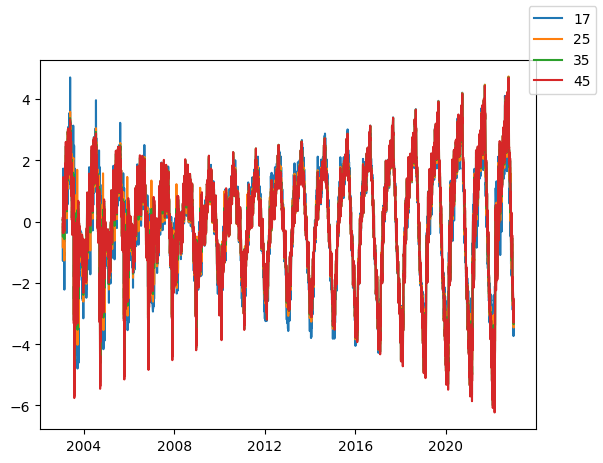

In [5]:
#test STl seasonal smoother:
seasonal_options = [17, 25, 35, 45]
dt_STL = frc_all_STL.indexes['time'].to_datetimeindex()
fig,ax = plt.subplots(1,1)

for seas in seasonal_options:
    stl_frALL = STL(frc_all_STL, period=365, seasonal=seas, robust=True)
    res_frALL = stl_frALL.fit()
    ax.plot(dt_STL, res_frALL.seasonal,label=seas)

fig.legend()

    

/tmp/ipykernel_1408816/357024606.py:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  dt_STLall = frc_all_STL.indexes['time'].to_datetimeindex()
/tmp/ipykernel_1408816/357024606.py:5: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  dt_STLallp = pw_all_STL.indexes['time'].to_datetimeindex()
/tmp/ipykernel_1408816/357024606.py:9: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time

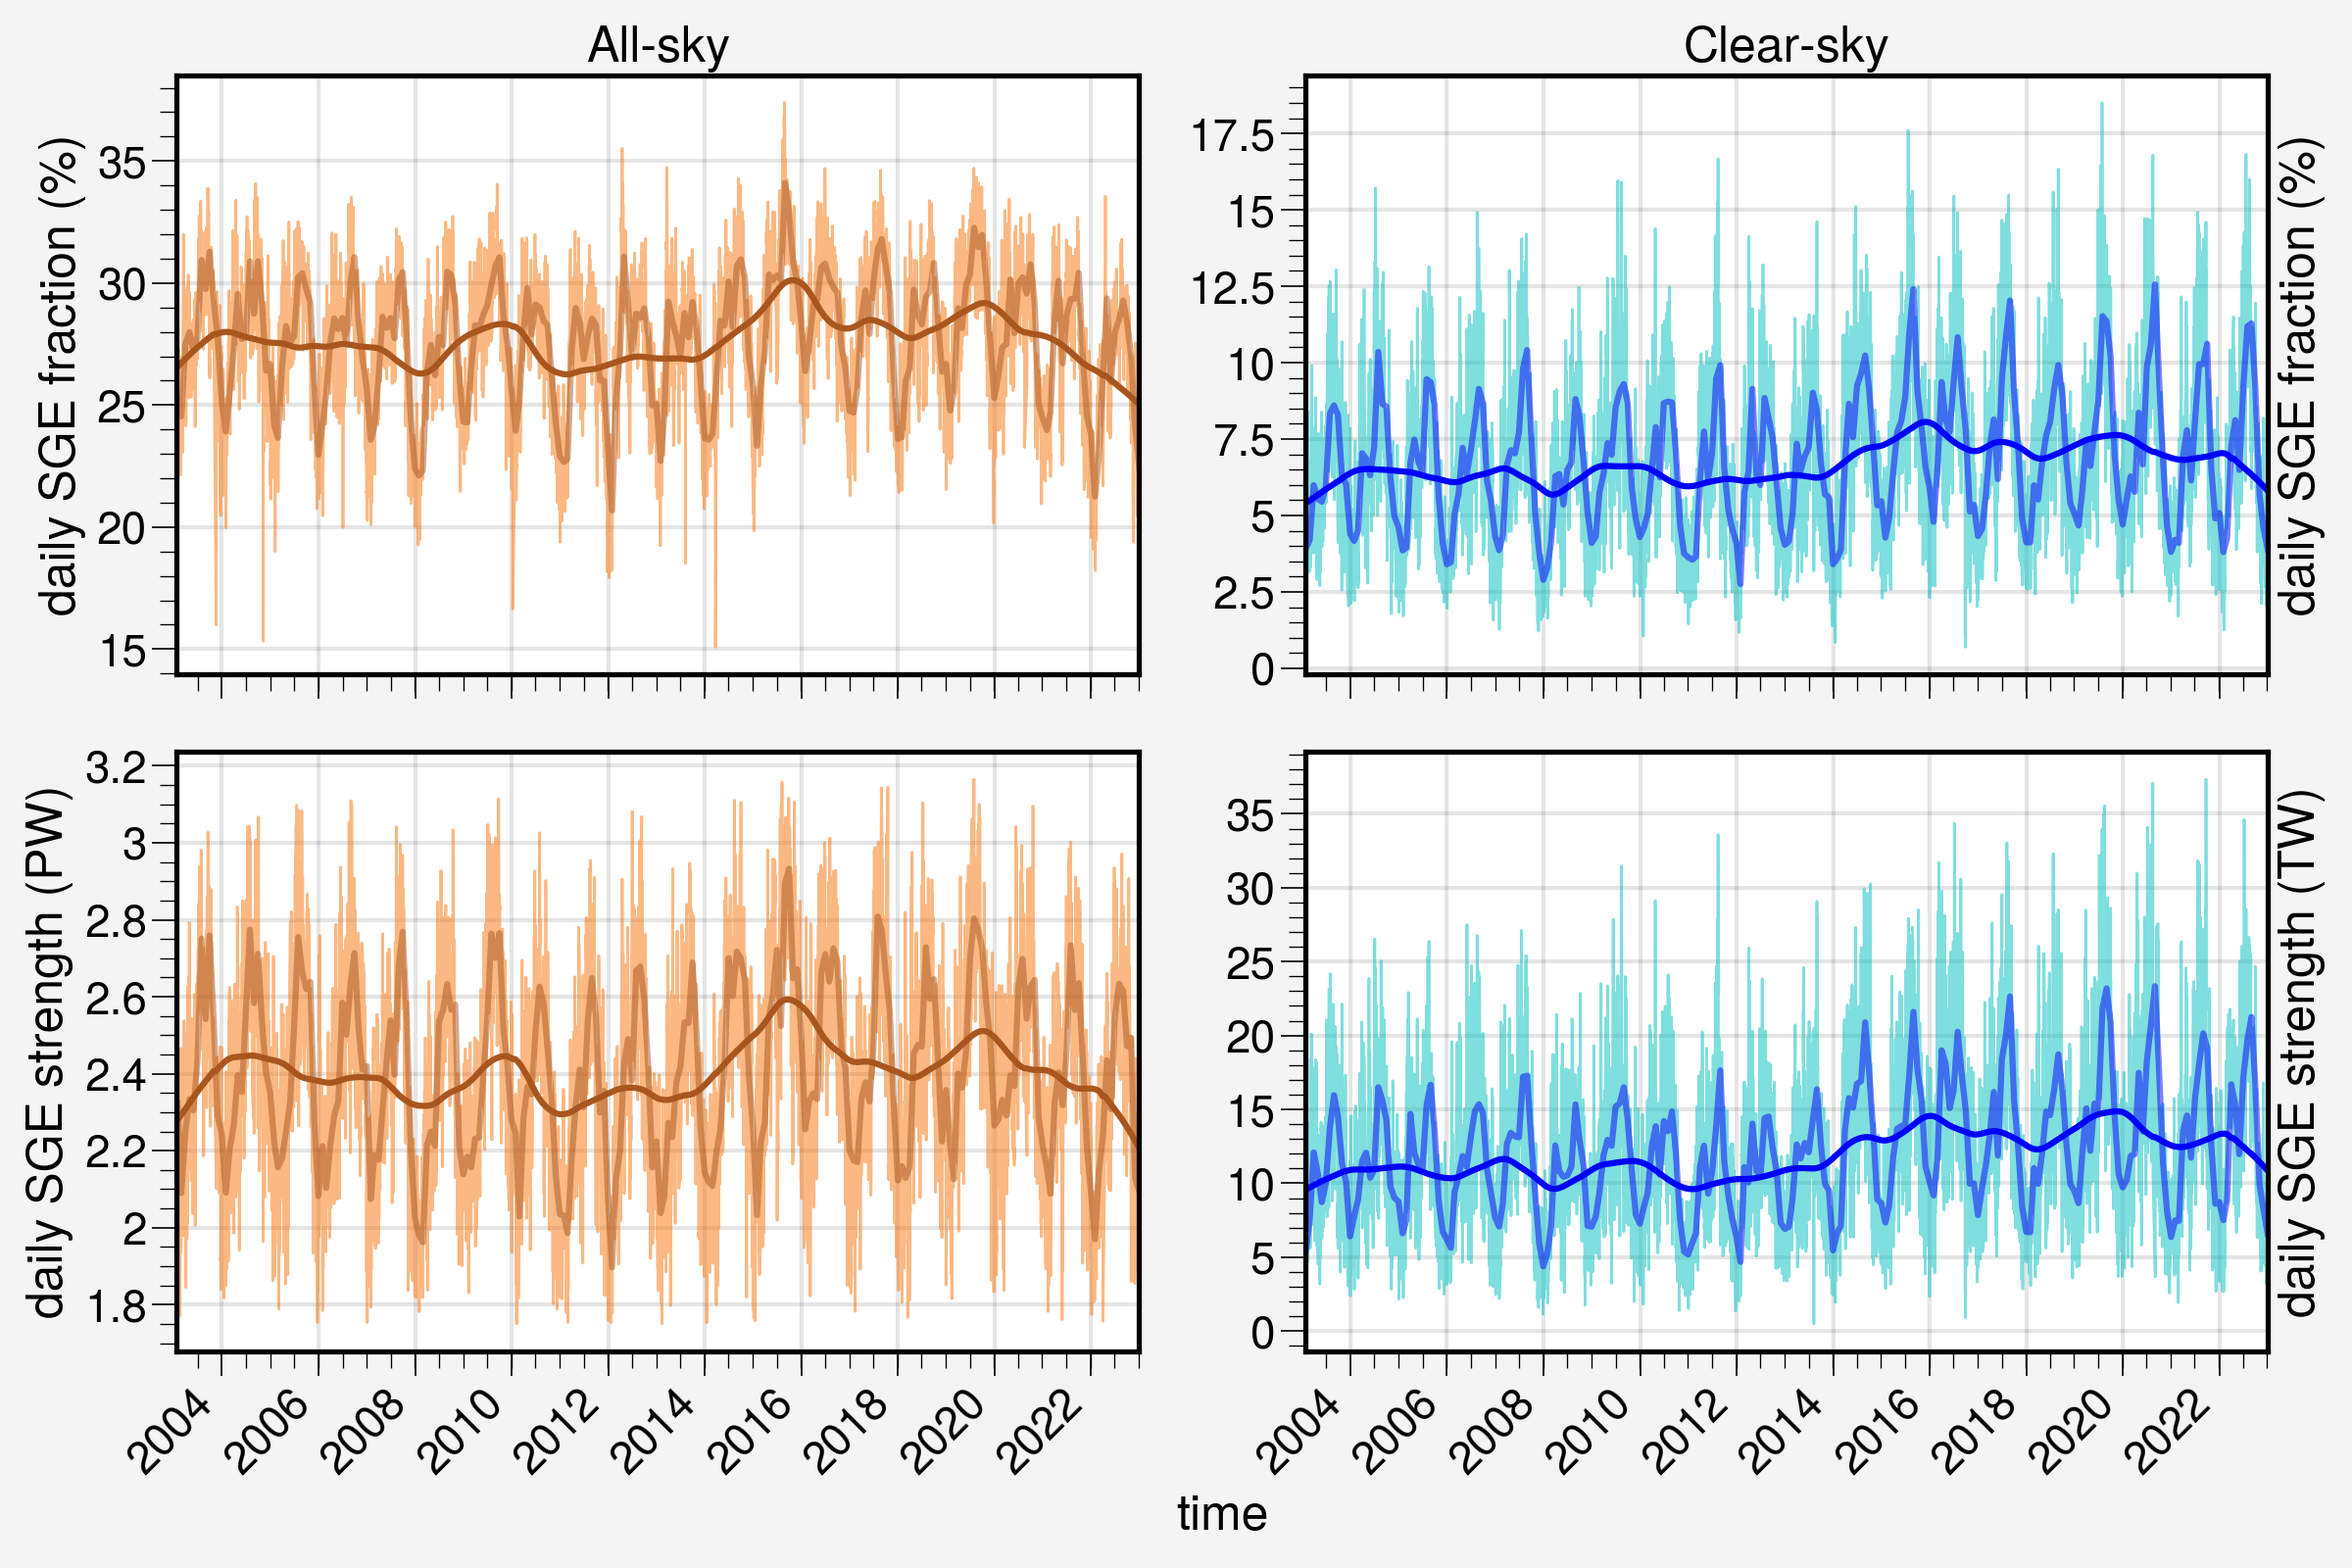

In [8]:
#Figure 1, timeseries trends
with sns.plotting_context("talk"):

    dt_STLall = frc_all_STL.indexes['time'].to_datetimeindex()
    dt_STLallp = pw_all_STL.indexes['time'].to_datetimeindex()
    dt_all = frc_all_clean['time']
    dt_allp = pw_all_clean['time']
    
    dt_STLclr = frc_clr_STL.indexes['time'].to_datetimeindex()
    dt_clr = frc_clr_clean['time']

    dt_mm = frc_all_clean.resample(time='M', skipna=True).mean()['time']

    fig, axes = pplt.subplots(nrows=2, ncols=2, figsize=(12,8), sharex=True, sharey=False)
    axes[0].plot(dt_all, frc_all_clean,color='orange',linewidth=1,alpha=0.5)
    axes[0].plot(dt_mm, frc_all_clean.resample(time='M', skipna=True).mean(), color='sienna',alpha=0.5)
    axes[0].plot(dt_STLall, res_frALL.trend,color='sienna')
    #axes[0].axvline(x=pd.to_datetime('2016-09-27'))
    #axes[0,0].autoscale(enable=True, axis='x', tight=True)
    axes[0].set_title('All-sky')
    axes[0].set_ylabel('daily SGE fraction (%)')
    
    axes[1].plot(dt_clr, frc_clr_clean, linewidth=1,color='c',alpha=0.5)
    axes[1].plot(dt_mm, frc_clr_clean.resample(time='M', skipna=True).mean(), color='b',alpha=0.5)
    axes[1].plot(dt_STLclr, res_frCLR.trend, color='b')
    #axes[1].axvline(x=pd.to_datetime('2016-09-27'))
    axes[1].set_title('Clear-sky')
    #axes[0,1].autoscale(enable=True, axis='x', tight=True)
    #axes[0,1].yaxis.tick_right()
    axes[1].yaxis.set_label_position("right")
    axes[1].set_ylabel('daily SGE fraction (%)')

    axes[2].plot(dt_allp, pw_all_clean, color='orange',linewidth=1,alpha=0.5)
    axes[2].plot(dt_mm, pw_all_clean.resample(time='M', skipna=True).mean(), color='sienna',alpha=0.5)
    axes[2].plot(dt_STLallp, res_pwALL.trend,color='sienna')
    #axes[2].axvline(x=pd.to_datetime('2016-09-27'))
    #axes[1,0].autoscale(enable=True, axis='x', tight=True)
    axes[2].set_ylabel('daily SGE strength (PW)')
    axes[2].format(xrotation=45)

    axes[3].plot(dt_clr, pw_clr_clean, linewidth=1,color='c',alpha=0.5)
    axes[3].plot(dt_mm, pw_clr_clean.resample(time='M', skipna=True).mean(), color='b',alpha=0.5)
    axes[3].plot(dt_STLclr, res_pwCLR.trend, color='b')
    #axes[3].axvline(x=pd.to_datetime('2016-09-27'))
    #axes[1,1].autoscale(enable=True, axis='x', tight=True)
    #axes[1,1].yaxis.tick_right()
    axes[3].yaxis.set_label_position("right")
    axes[3].set_ylabel('daily SGE strength (TW)')
    axes[3].format(xrotation=45)



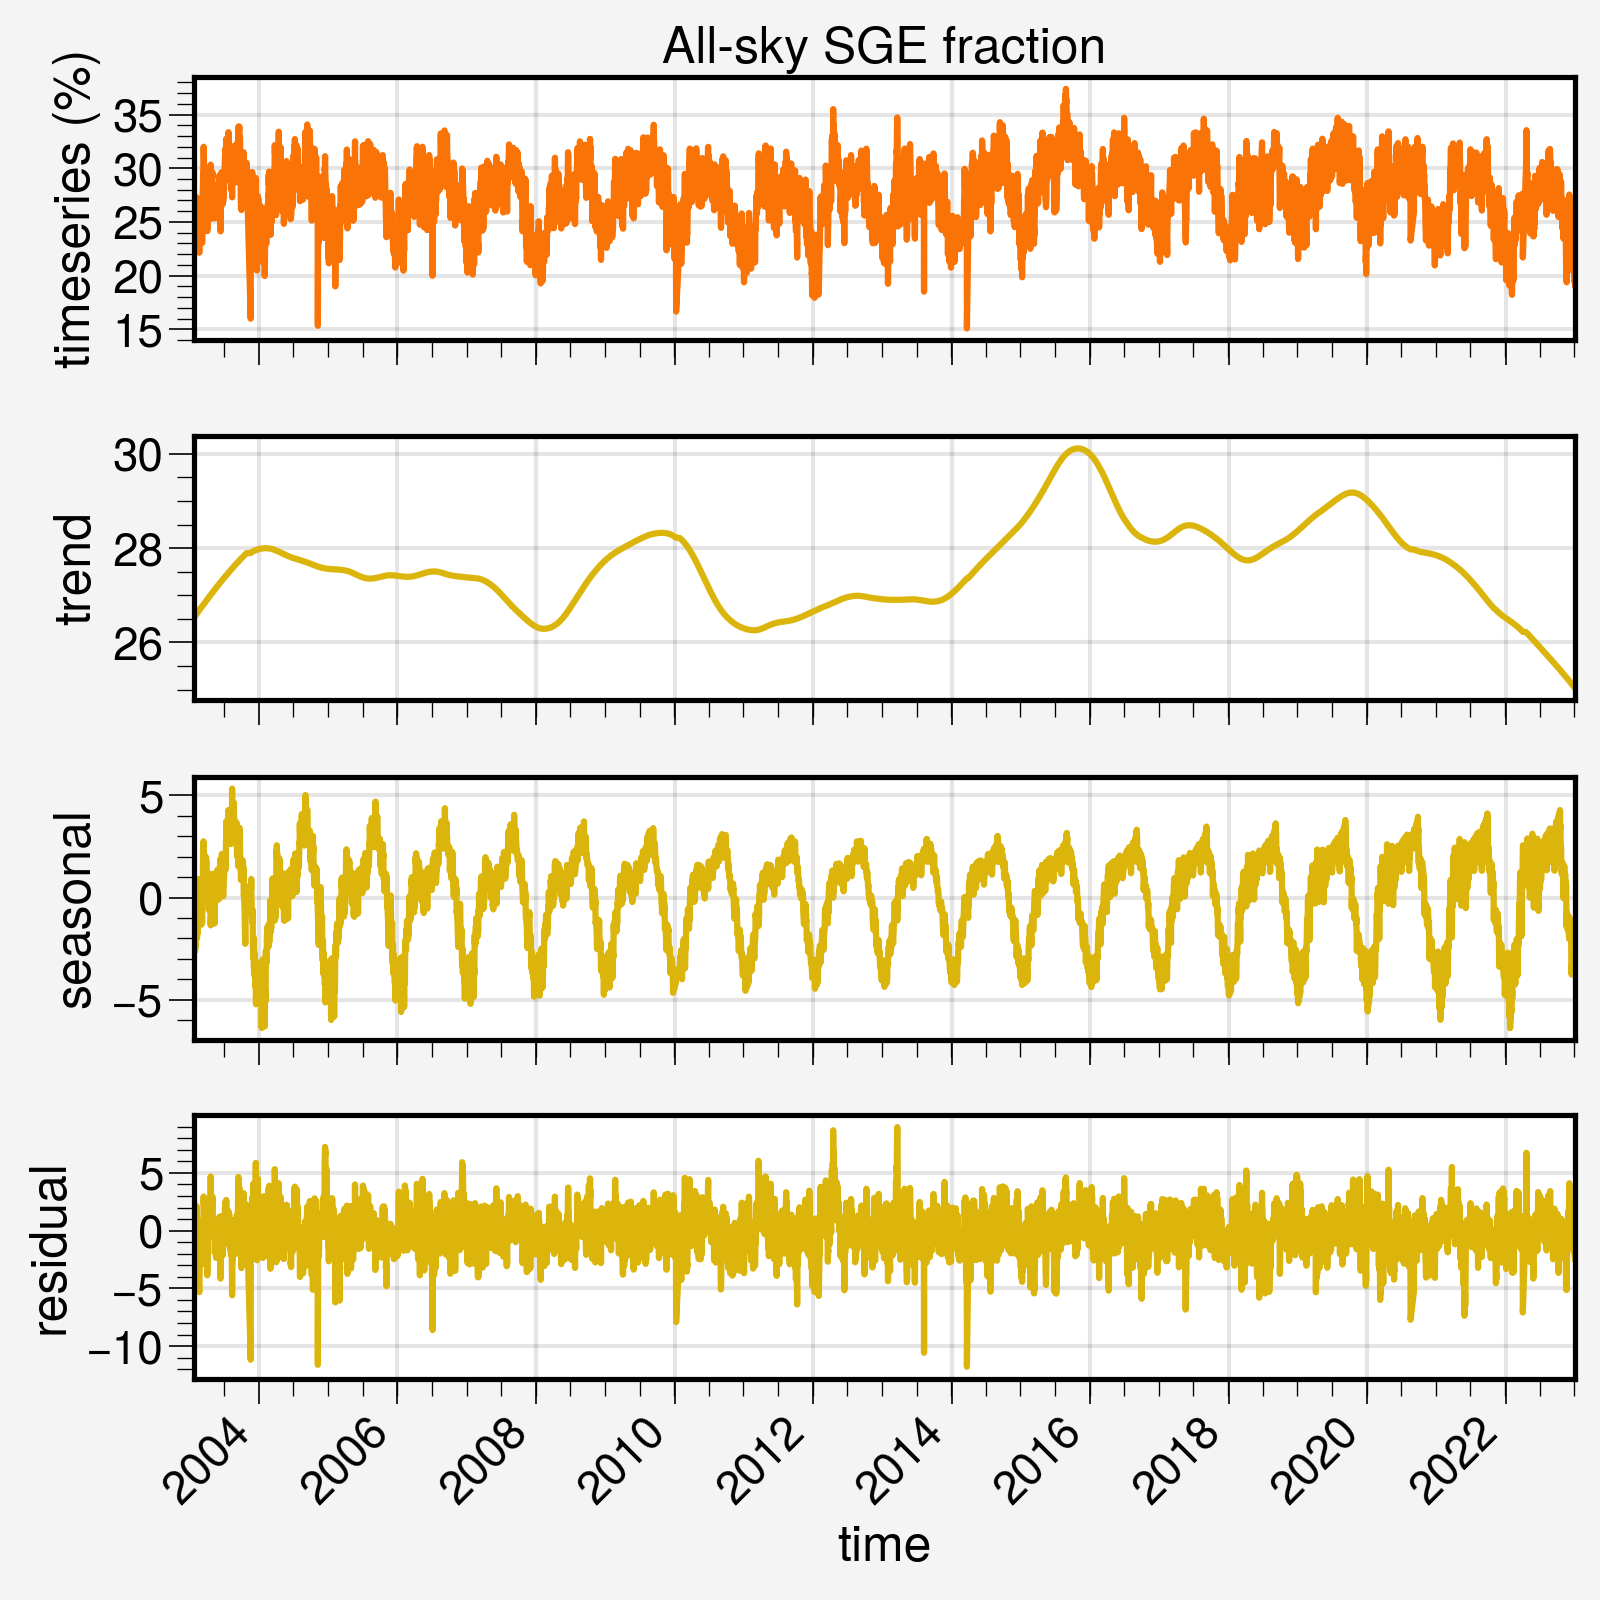

In [10]:
#plot full decomposition of each timeseries for supplimentary:

with sns.plotting_context("talk"):
    fig, axes = pplt.subplots(nrows=4,ncols=1, figsize=(8,8), sharex=True, sharey=False)
    axes[0].plot(dt_all, frc_all_clean,color='orange')
    axes[0].autoscale(enable=True, axis='x', tight=True)
    axes[0].set_title('All-sky SGE fraction')
    axes[0].set_ylabel('timeseries (%)')

    axes[1].plot(dt_STLall, res_frALL.trend,color='gold')
    #axes[1].axvline(x=pd.to_datetime('2016-09-27'))
    axes[1].autoscale(enable=True, axis='x', tight=True)
    axes[1].set_ylabel('trend')

    axes[2].plot(dt_STLall, res_frALL.seasonal,color='gold')
    axes[2].autoscale(enable=True, axis='x', tight=True)
    axes[2].set_ylabel('seasonal')

    axes[3].plot(dt_STLall, res_frALL.resid,color='gold')
    axes[3].autoscale(enable=True, axis='x', tight=True)
    axes[3].set_ylabel('residual')
    axes[3].format(xrotation=45)



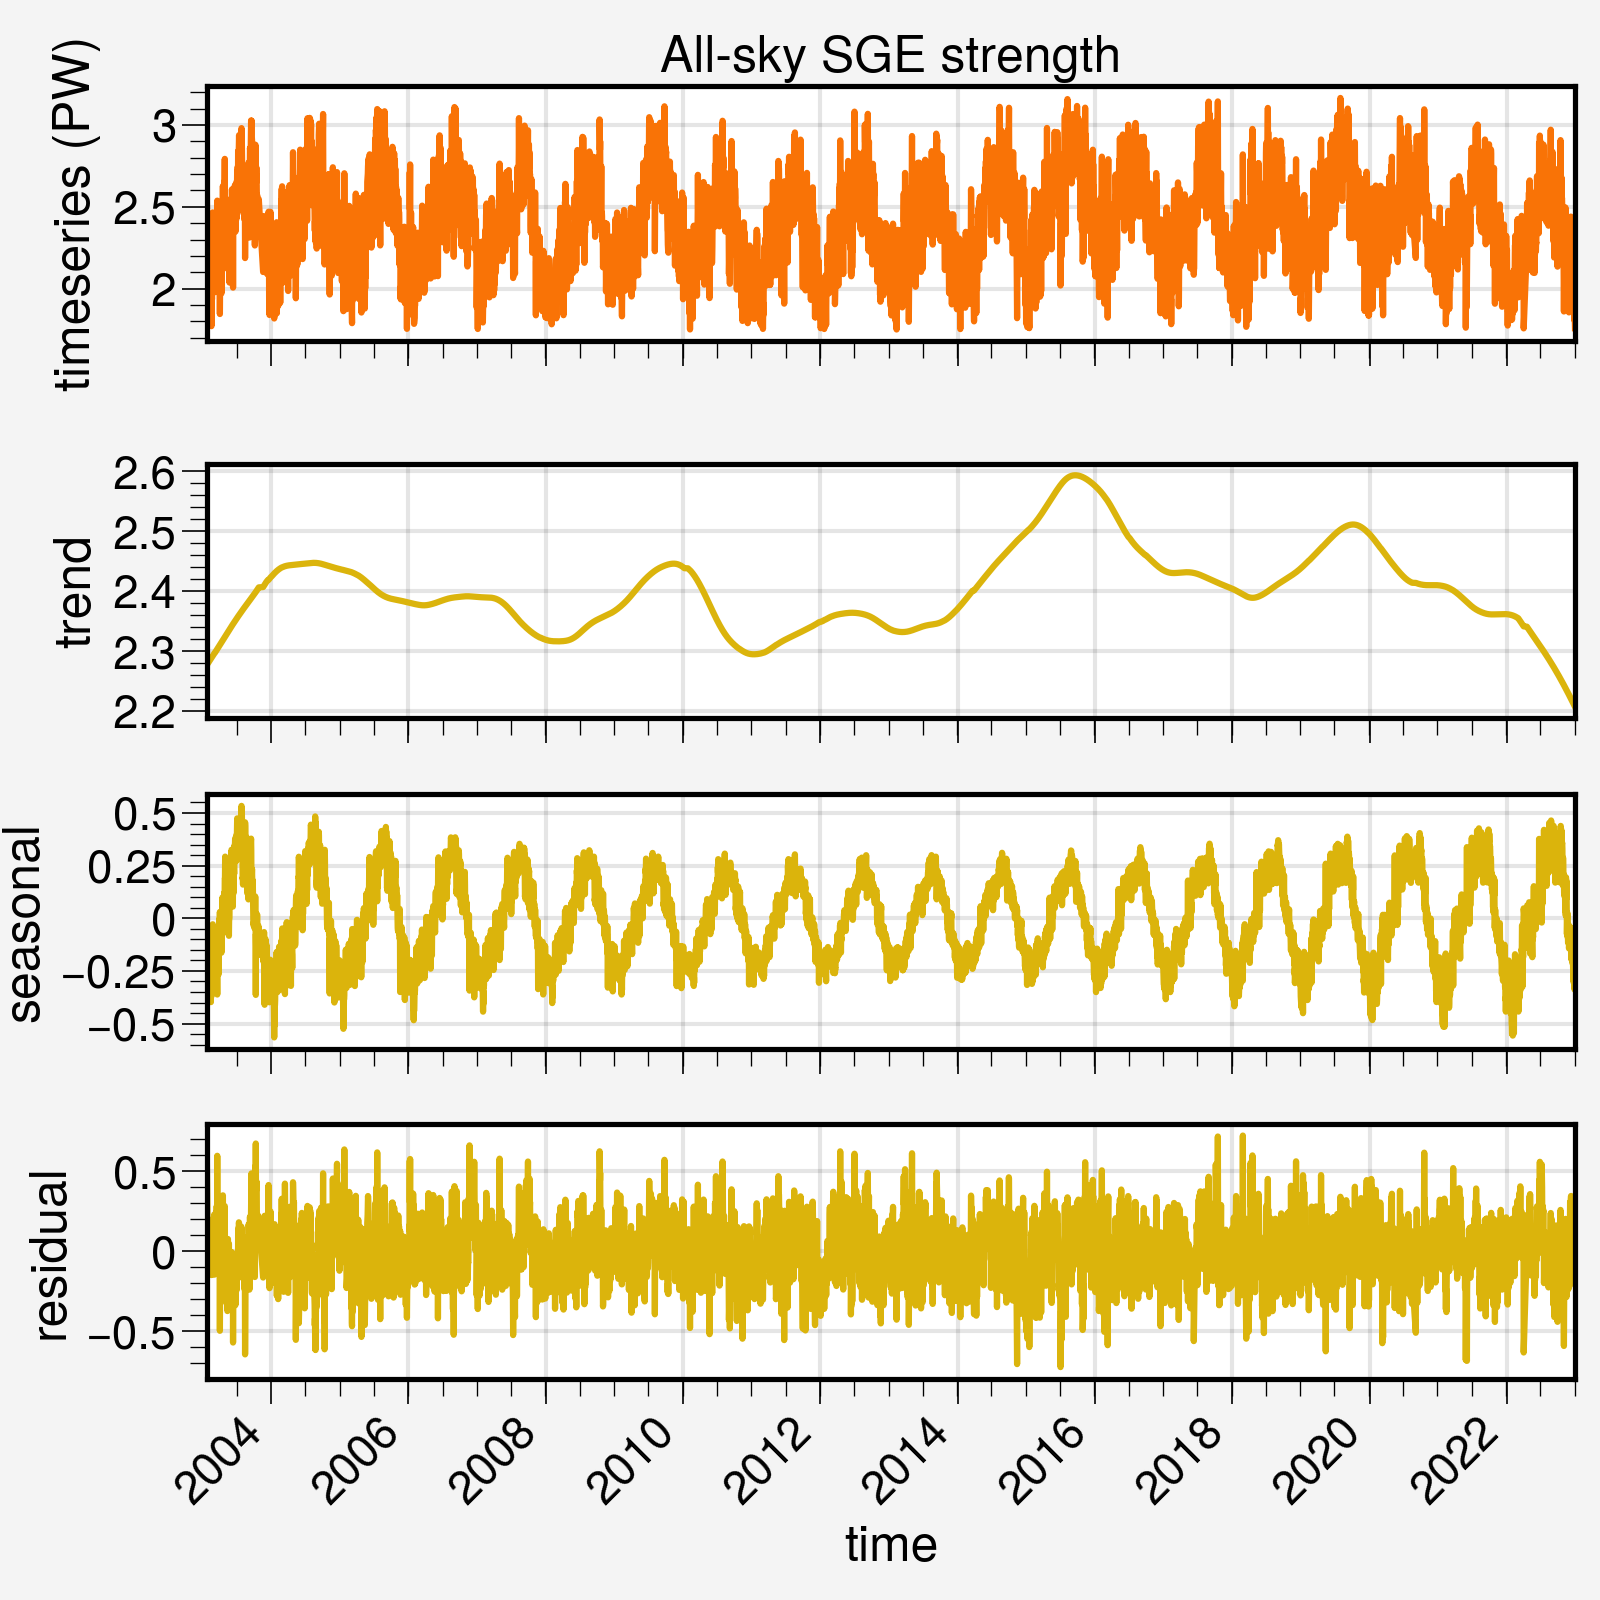

In [11]:
#plot full decomposition of each timeseries for supplimentary:

with sns.plotting_context("talk"):
    fig, axes = pplt.subplots(nrows=4,ncols=1, figsize=(8,8), sharex=True,sharey=False)
    axes[0].plot(dt_allp, pw_all_clean,color='orange')
    axes[0].autoscale(enable=True, axis='x', tight=True)
    axes[0].set_title('All-sky SGE strength')
    axes[0].set_ylabel('timeseries (PW)')

    axes[1].plot(dt_STLallp, res_pwALL.trend,color='gold')
    #axes[1].axvline(x=pd.to_datetime('2016-09-27'))
    axes[1].autoscale(enable=True, axis='x', tight=True)
    axes[1].set_ylabel('trend')

    axes[2].plot(dt_STLallp, res_pwALL.seasonal,color='gold')
    axes[2].autoscale(enable=True, axis='x', tight=True)
    axes[2].set_ylabel('seasonal')

    axes[3].plot(dt_STLallp, res_pwALL.resid,color='gold')
    axes[3].autoscale(enable=True, axis='x', tight=True)
    axes[3].set_ylabel('residual')
    axes[3].format(xrotation=45)

/tmp/ipykernel_1408816/1771950205.py:10: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  axes[1].plot(frc_clr_STL.indexes['time'].to_datetimeindex(), res_frCLR.trend,color='skyblue')
/tmp/ipykernel_1408816/1771950205.py:15: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  axes[2].plot(frc_clr_STL.indexes['time'].to_datetimeindex(), res_frCLR.seasonal,color='skyblue')
/tmp/ipykernel_1408816/1771950205.py:19: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar. 

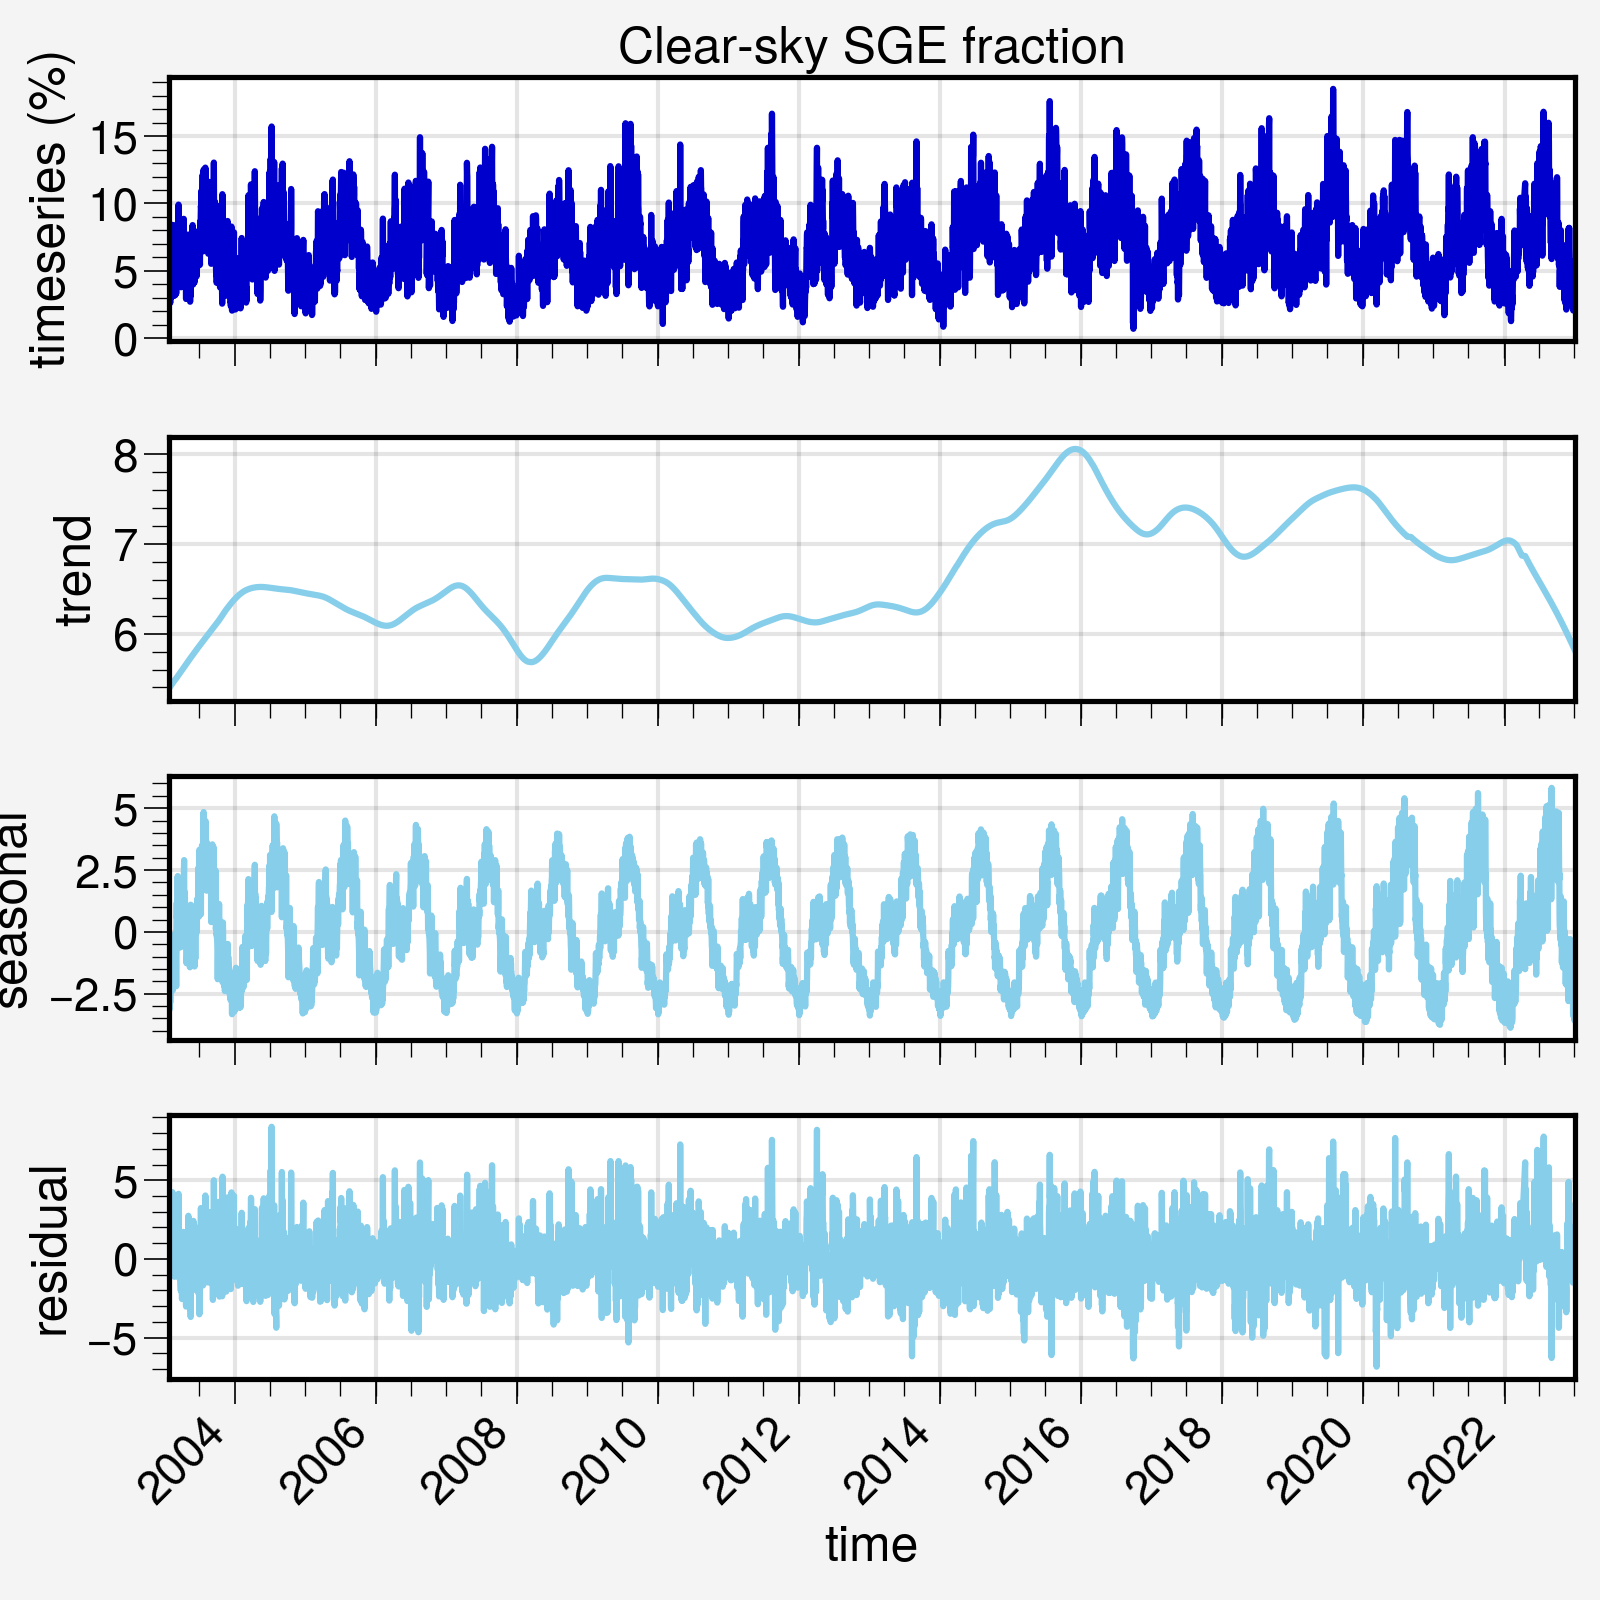

In [12]:
#plot full decomposition of each timeseries for supplimentary:

with sns.plotting_context("talk"):
    fig, axes = pplt.subplots(nrows=4,ncols=1, figsize=(8,8), sharex=True,sharey=False)
    axes[0].plot(dt_clr, frc_clr_clean,color='mediumblue')
    axes[0].autoscale(enable=True, axis='x', tight=True)
    axes[0].set_title('Clear-sky SGE fraction')
    axes[0].set_ylabel('timeseries (%)')

    axes[1].plot(frc_clr_STL.indexes['time'].to_datetimeindex(), res_frCLR.trend,color='skyblue')
    #axes[1].axvline(x=pd.to_datetime('2016-09-27'))
    axes[1].autoscale(enable=True, axis='x', tight=True)
    axes[1].set_ylabel('trend')

    axes[2].plot(frc_clr_STL.indexes['time'].to_datetimeindex(), res_frCLR.seasonal,color='skyblue')
    axes[2].autoscale(enable=True, axis='x', tight=True)
    axes[2].set_ylabel('seasonal')

    axes[3].plot(frc_clr_STL.indexes['time'].to_datetimeindex(), res_frCLR.resid,color='skyblue')
    axes[3].autoscale(enable=True, axis='x', tight=True)
    axes[3].set_ylabel('residual')
    axes[3].format(xrotation=45)

/tmp/ipykernel_1408816/3046726108.py:10: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  axes[1].plot(pw_clr_STL.indexes['time'].to_datetimeindex(), res_pwCLR.trend,color='skyblue')
/tmp/ipykernel_1408816/3046726108.py:15: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  axes[2].plot(pw_clr_STL.indexes['time'].to_datetimeindex(), res_pwCLR.seasonal,color='skyblue')
/tmp/ipykernel_1408816/3046726108.py:19: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  T

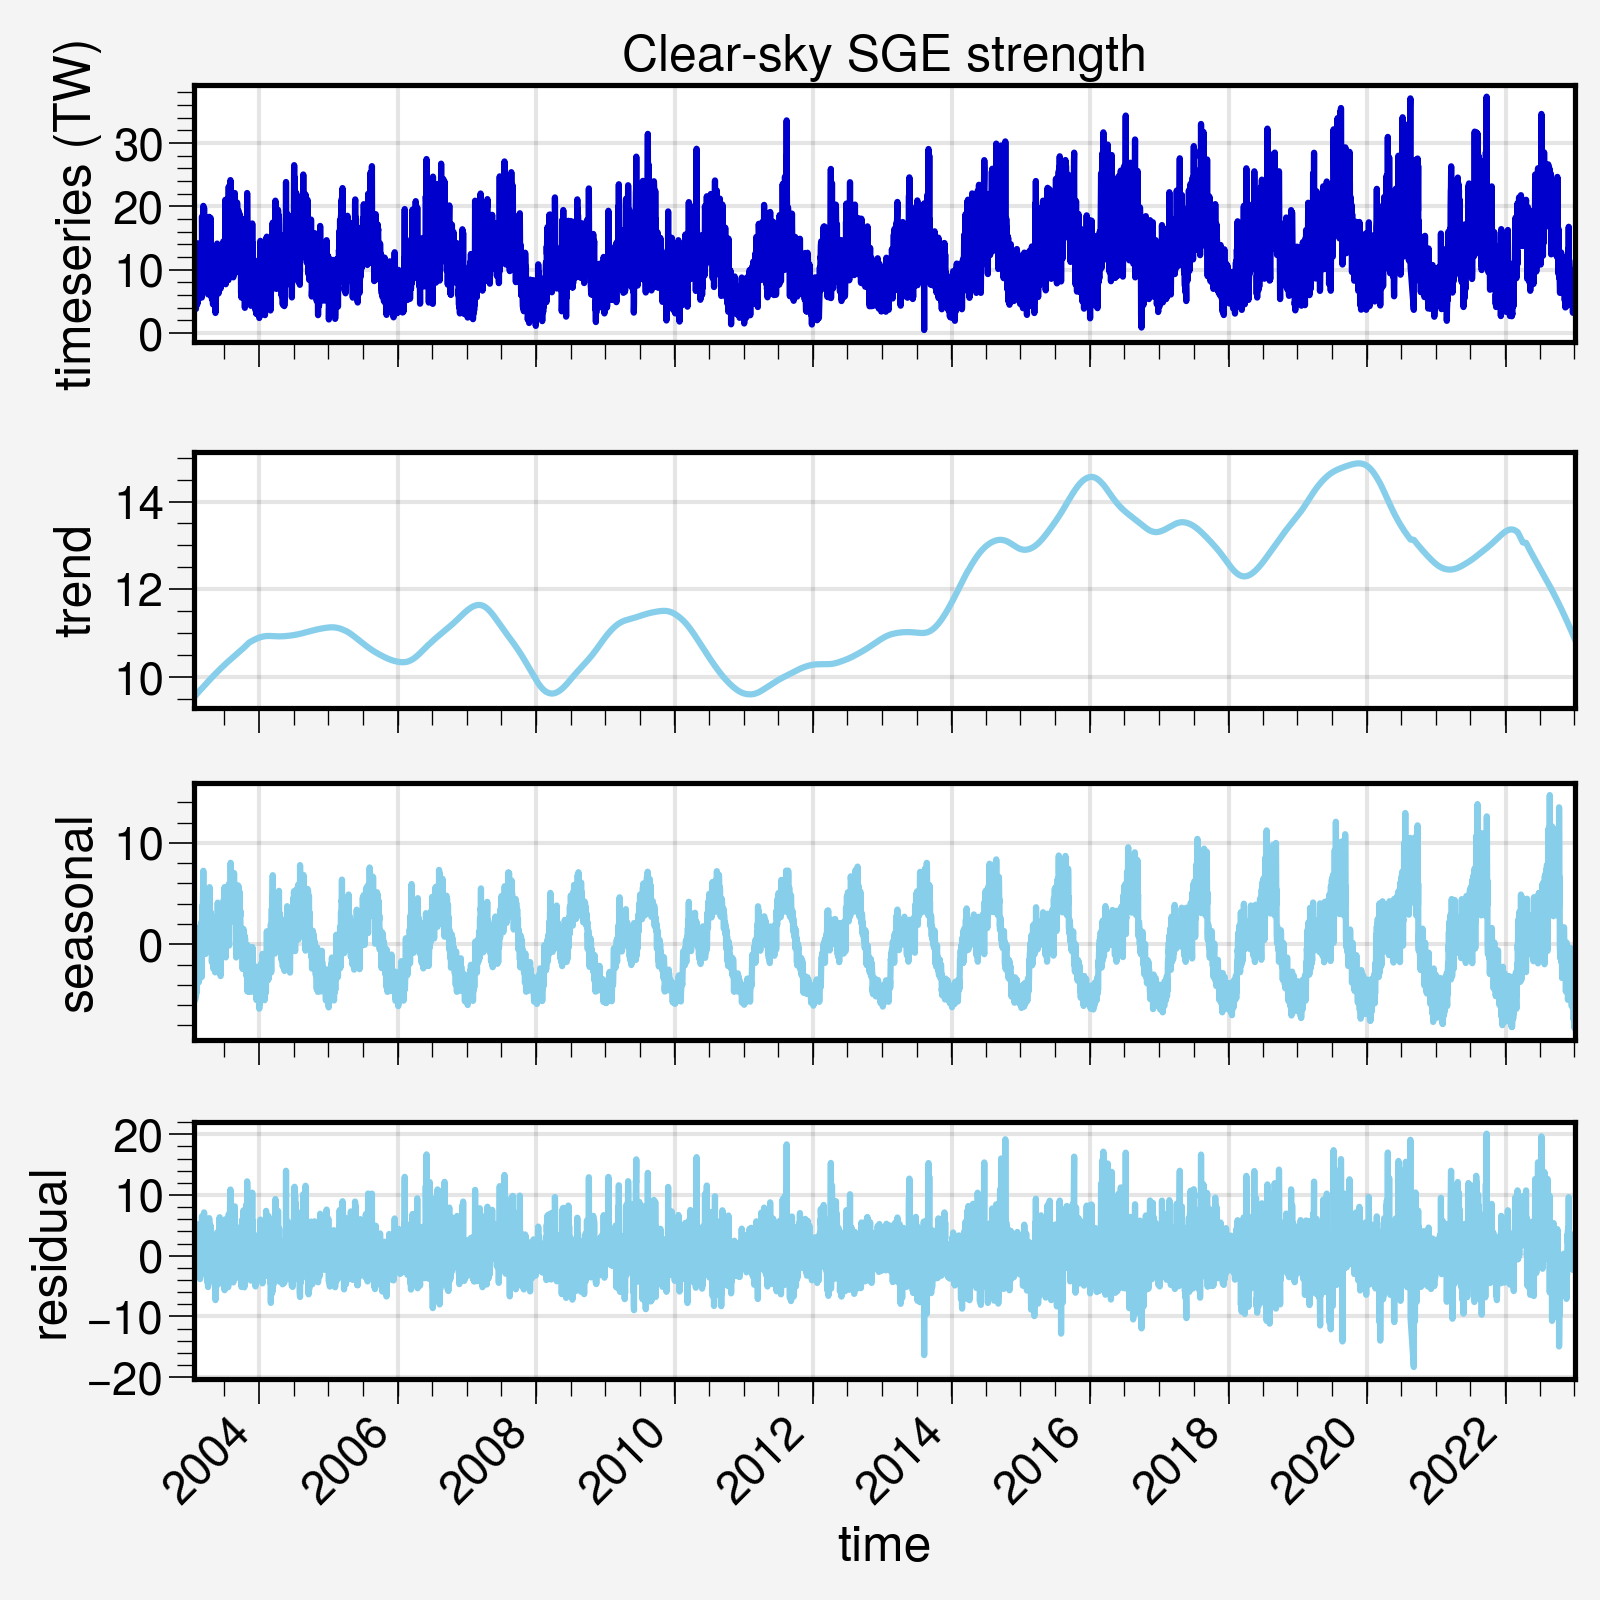

In [13]:
#plot full decomposition of each timeseries for supplimentary:

with sns.plotting_context("talk"):
    fig, axes = pplt.subplots(nrows=4,ncols=1, figsize=(8,8), sharex=True,sharey=False)
    axes[0].plot(dt_clr, pw_clr_clean,color='mediumblue')
    axes[0].autoscale(enable=True, axis='x', tight=True)
    axes[0].set_title('Clear-sky SGE strength')
    axes[0].set_ylabel('timeseries (TW)')

    axes[1].plot(pw_clr_STL.indexes['time'].to_datetimeindex(), res_pwCLR.trend,color='skyblue')
    #axes[1].axvline(x=pd.to_datetime('2016-09-27'))
    axes[1].autoscale(enable=True, axis='x', tight=True)
    axes[1].set_ylabel('trend')

    axes[2].plot(pw_clr_STL.indexes['time'].to_datetimeindex(), res_pwCLR.seasonal,color='skyblue')
    axes[2].autoscale(enable=True, axis='x', tight=True)
    axes[2].set_ylabel('seasonal')

    axes[3].plot(pw_clr_STL.indexes['time'].to_datetimeindex(), res_pwCLR.resid,color='skyblue')
    axes[3].autoscale(enable=True, axis='x', tight=True)
    axes[3].set_ylabel('residual')
    axes[3].format(xrotation=45)

In [6]:
#Figure 2: Annual cycles

#transform to dataframe with column for each year
#df_frALL = frc_all_clean.resample(time='MS').mean().to_dataframe()
#df_frALL['year'] = df_frALL.index.year
#df_frALL['month'] = df_frALL.index.month

df_pwALL = pw_all_clean.to_dataframe()
df_pwALL['year'] = df_pwALL.index.year
df_pwALL['DayOfYear'] = df_pwALL.index.dayofyear
df_frALL = frc_all_clean.to_dataframe()
df_ALL = pd.concat([df_pwALL, df_frALL], axis=1)

df_pwCLR = pw_clr_clean.to_dataframe()
df_pwCLR['year'] = df_pwCLR.index.year
df_pwCLR['DayOfYear'] = df_pwCLR.index.dayofyear
df_frCLR = frc_clr_clean.to_dataframe()
df_CLR = pd.concat([df_pwCLR, df_frCLR], axis=1)

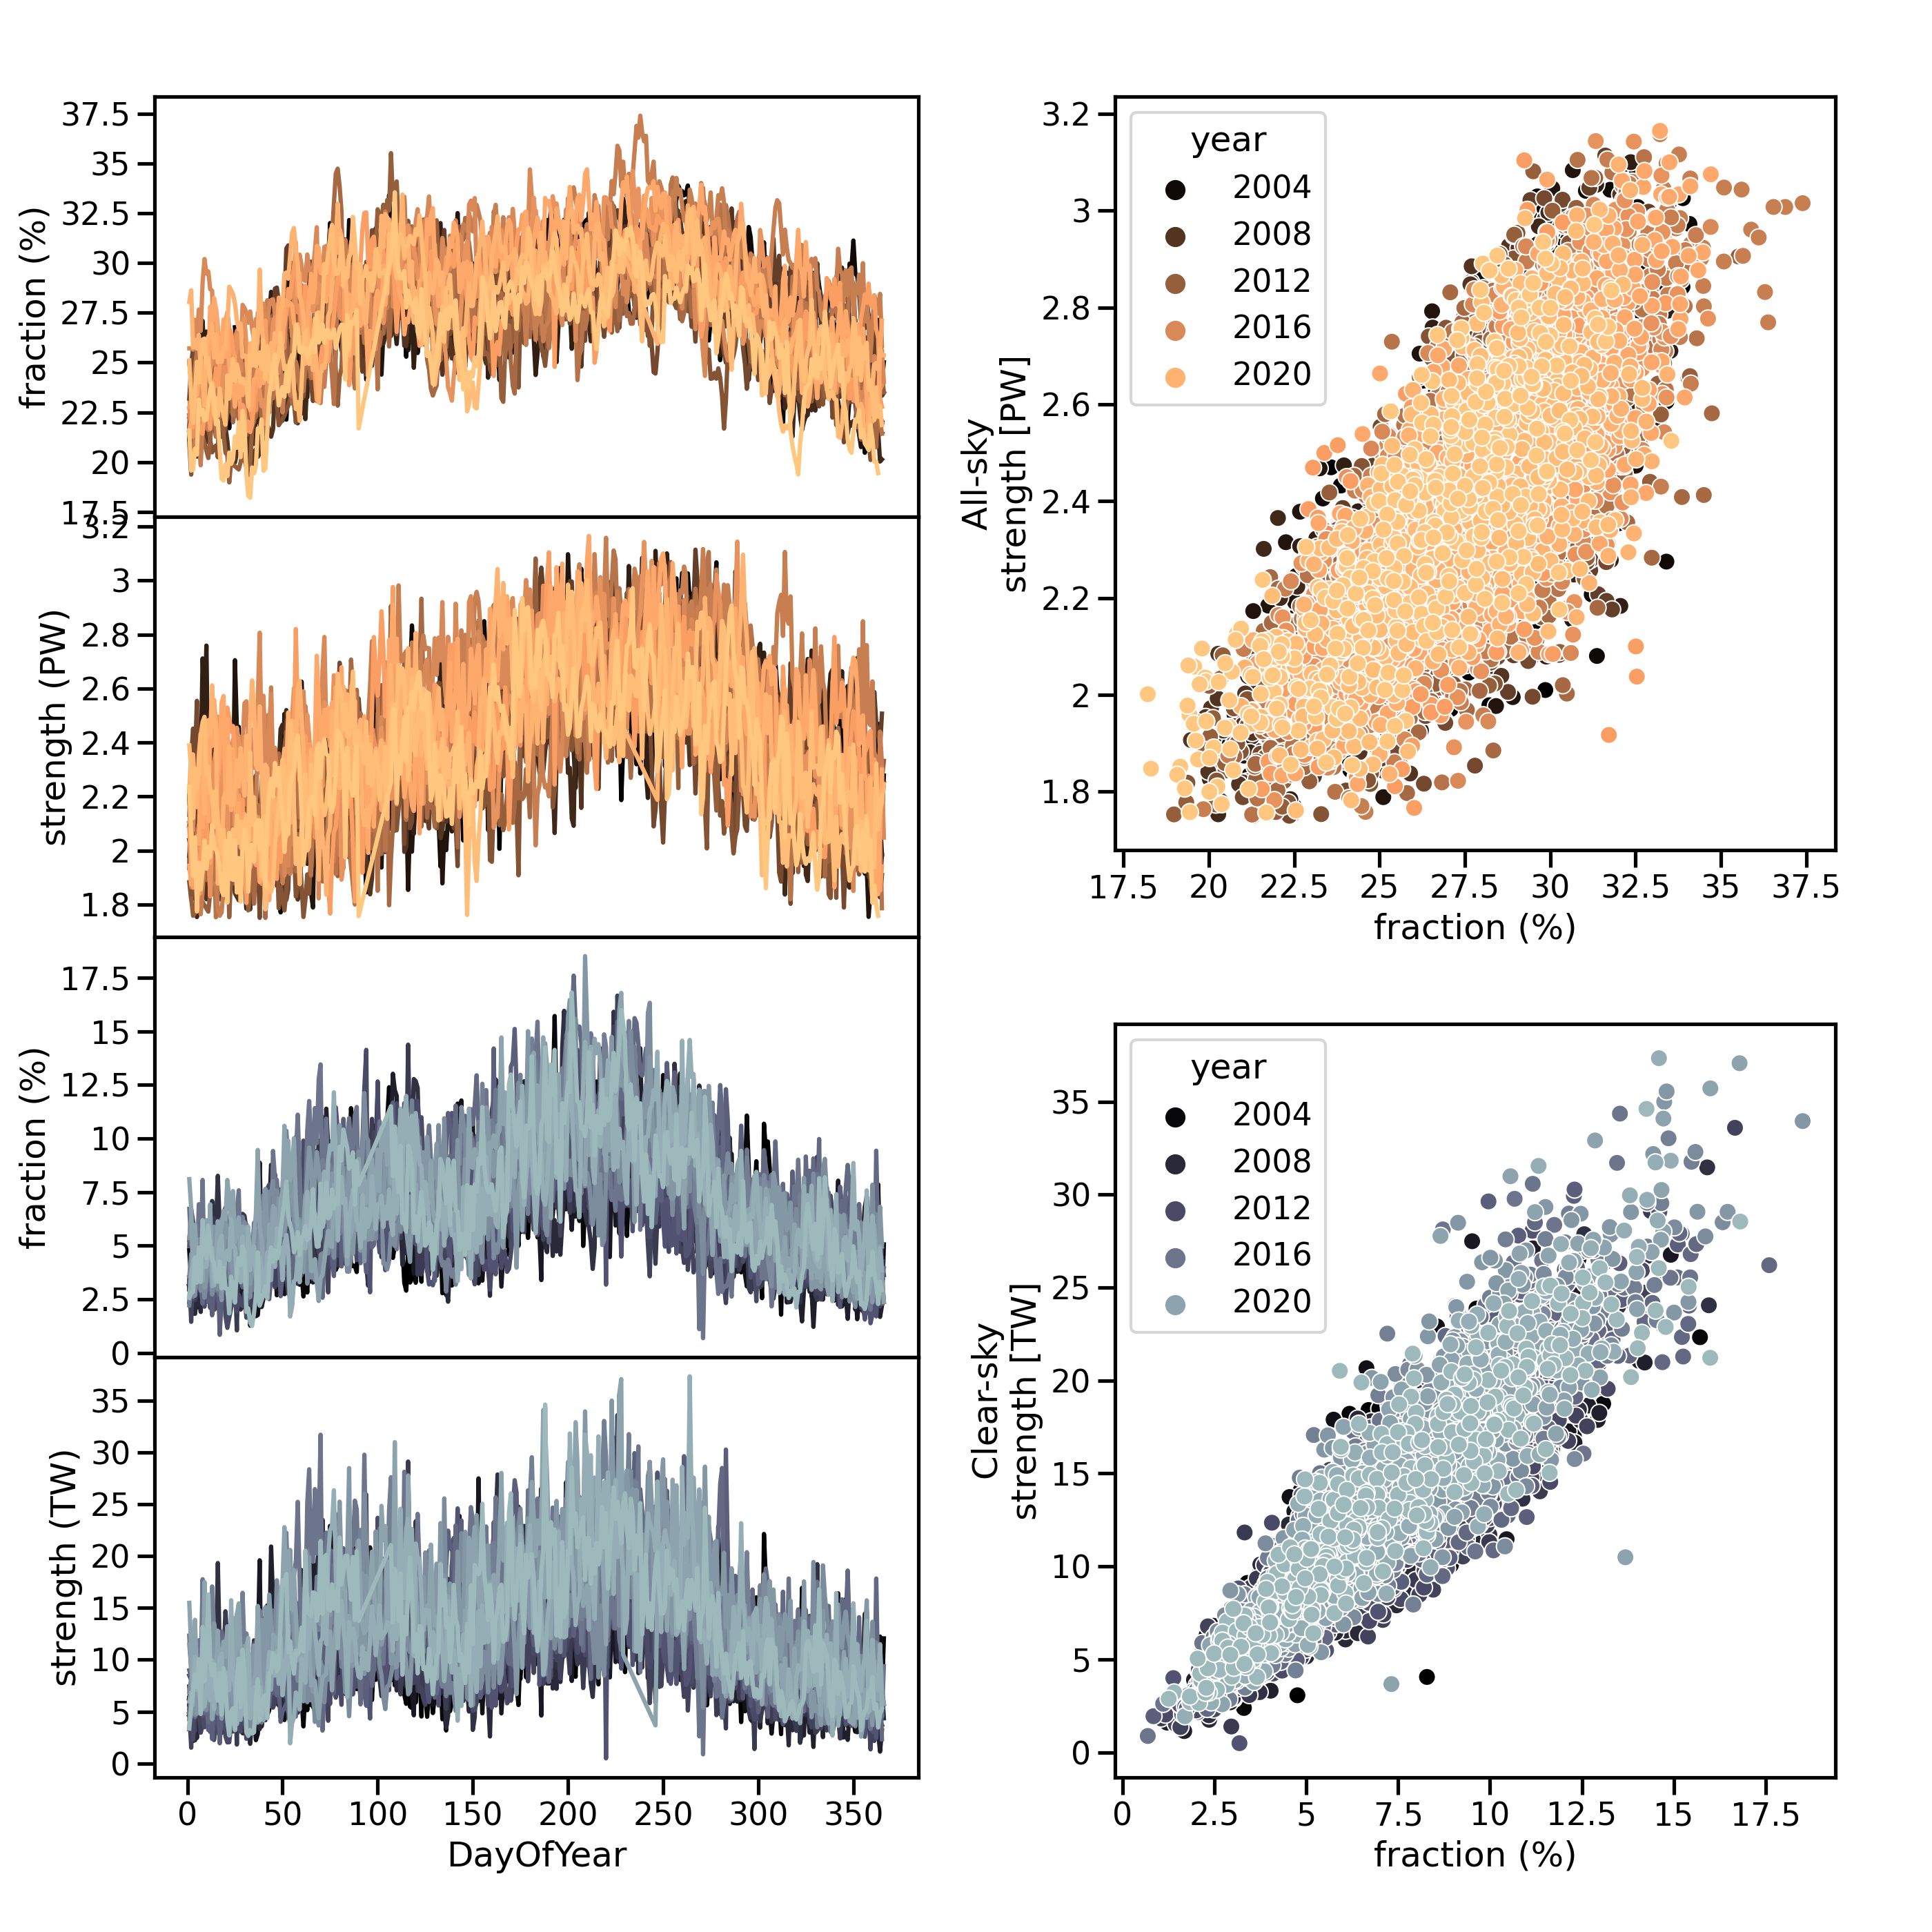

In [13]:
# Figure 2:
plt.rcdefaults()
with sns.plotting_context("talk"):

    fig = plt.figure(figsize=(14,14))
    gs_left = gridspec.GridSpec(ncols=4, nrows=4, hspace = 0.0, wspace = 0.5)
    gs_right = gridspec.GridSpec(ncols=4, nrows=4, hspace=0.6, wspace=1)
    fig.subplots_adjust(left=0.08, right=0.95, bottom=0.08, top=0.95)

    ax1 = fig.add_subplot(gs_left[0,0:2])
    sns.lineplot(ax=ax1,data=df_ALL, x='DayOfYear',y='SGE_frac_all2',hue='year',palette='copper',legend=False)
    ax1.set_ylabel('fraction (%)')

    ax2 = fig.add_subplot(gs_left[1,0:2])
    sns.lineplot(ax=ax2,data=df_ALL, x='DayOfYear',y='SGE_pw_all',hue='year',palette='copper',legend=False)
    ax2.set_ylabel('strength (PW)')

    ax3 = fig.add_subplot(gs_left[2,0:2])
    sns.lineplot(data=df_CLR, x='DayOfYear',y='SGE_frac_clr2',hue='year',palette=cm.get_sub_cmap('bone', 0.0, 0.7),legend=False)
    ax3.set_ylabel('fraction (%)')

    ax4 = fig.add_subplot(gs_left[3,0:2])
    sns.lineplot(data=df_CLR, x='DayOfYear',y='SGE_pw_clr',hue='year',palette=cm.get_sub_cmap('bone', 0.0, 0.7),legend=False)
    ax4.set_ylabel('strength (TW)')

    ax5 = fig.add_subplot(gs_right[0:2,2:4])
    sns.scatterplot(ax=ax5,data=df_ALL,x='SGE_frac_all2',y='SGE_pw_all',hue='year',palette='copper')
    #sns.regplot(ax=ax5,data=df_ALL,x='SGE_frac_all',y='SGE_pw_all',scatter=False,color='orange',ci=None,robust=True)
    ax5.set_ylabel(' All-sky \nstrength [PW]')
    ax5.set_xlabel('fraction (%)')

    ax6 = fig.add_subplot(gs_right[2:4,2:4])
    sns.scatterplot(ax=ax6,data=df_CLR,x='SGE_frac_clr2',y='SGE_pw_clr',hue='year',palette=cm.get_sub_cmap('bone', 0.0, 0.7))
    #sns.regplot(ax=ax6,data=df_CLR,x='SGE_frac_clr',y='SGE_pw_clr',scatter=False,color='skyblue',ci=None,robust=True)
    ax6.set_ylabel(' Clear-sky \nstrength [TW]')
    ax6.set_xlabel('fraction (%)')




In [14]:
#Figure 2B: Annual cycles with monthly means

df_pwALLmm = pw_all_clean.resample(time='M', skipna=True).mean().to_dataframe()
df_pwALLmm['year'] = df_pwALLmm.index.year
df_pwALLmm['month'] = df_pwALLmm.index.month
df_frALLmm = frc_all_clean.resample(time='M', skipna=True).mean().to_dataframe()
df_ALLmm = pd.concat([df_pwALLmm, df_frALLmm], axis=1)

df_pwCLRmm = pw_clr_clean.resample(time='M', skipna=True).mean().to_dataframe()
df_pwCLRmm['year'] = df_pwCLRmm.index.year
df_pwCLRmm['month'] = df_pwCLRmm.index.month
df_frCLRmm = frc_clr_clean.resample(time='M', skipna=True).mean().to_dataframe()
df_CLRmm = pd.concat([df_pwCLRmm, df_frCLRmm], axis=1)

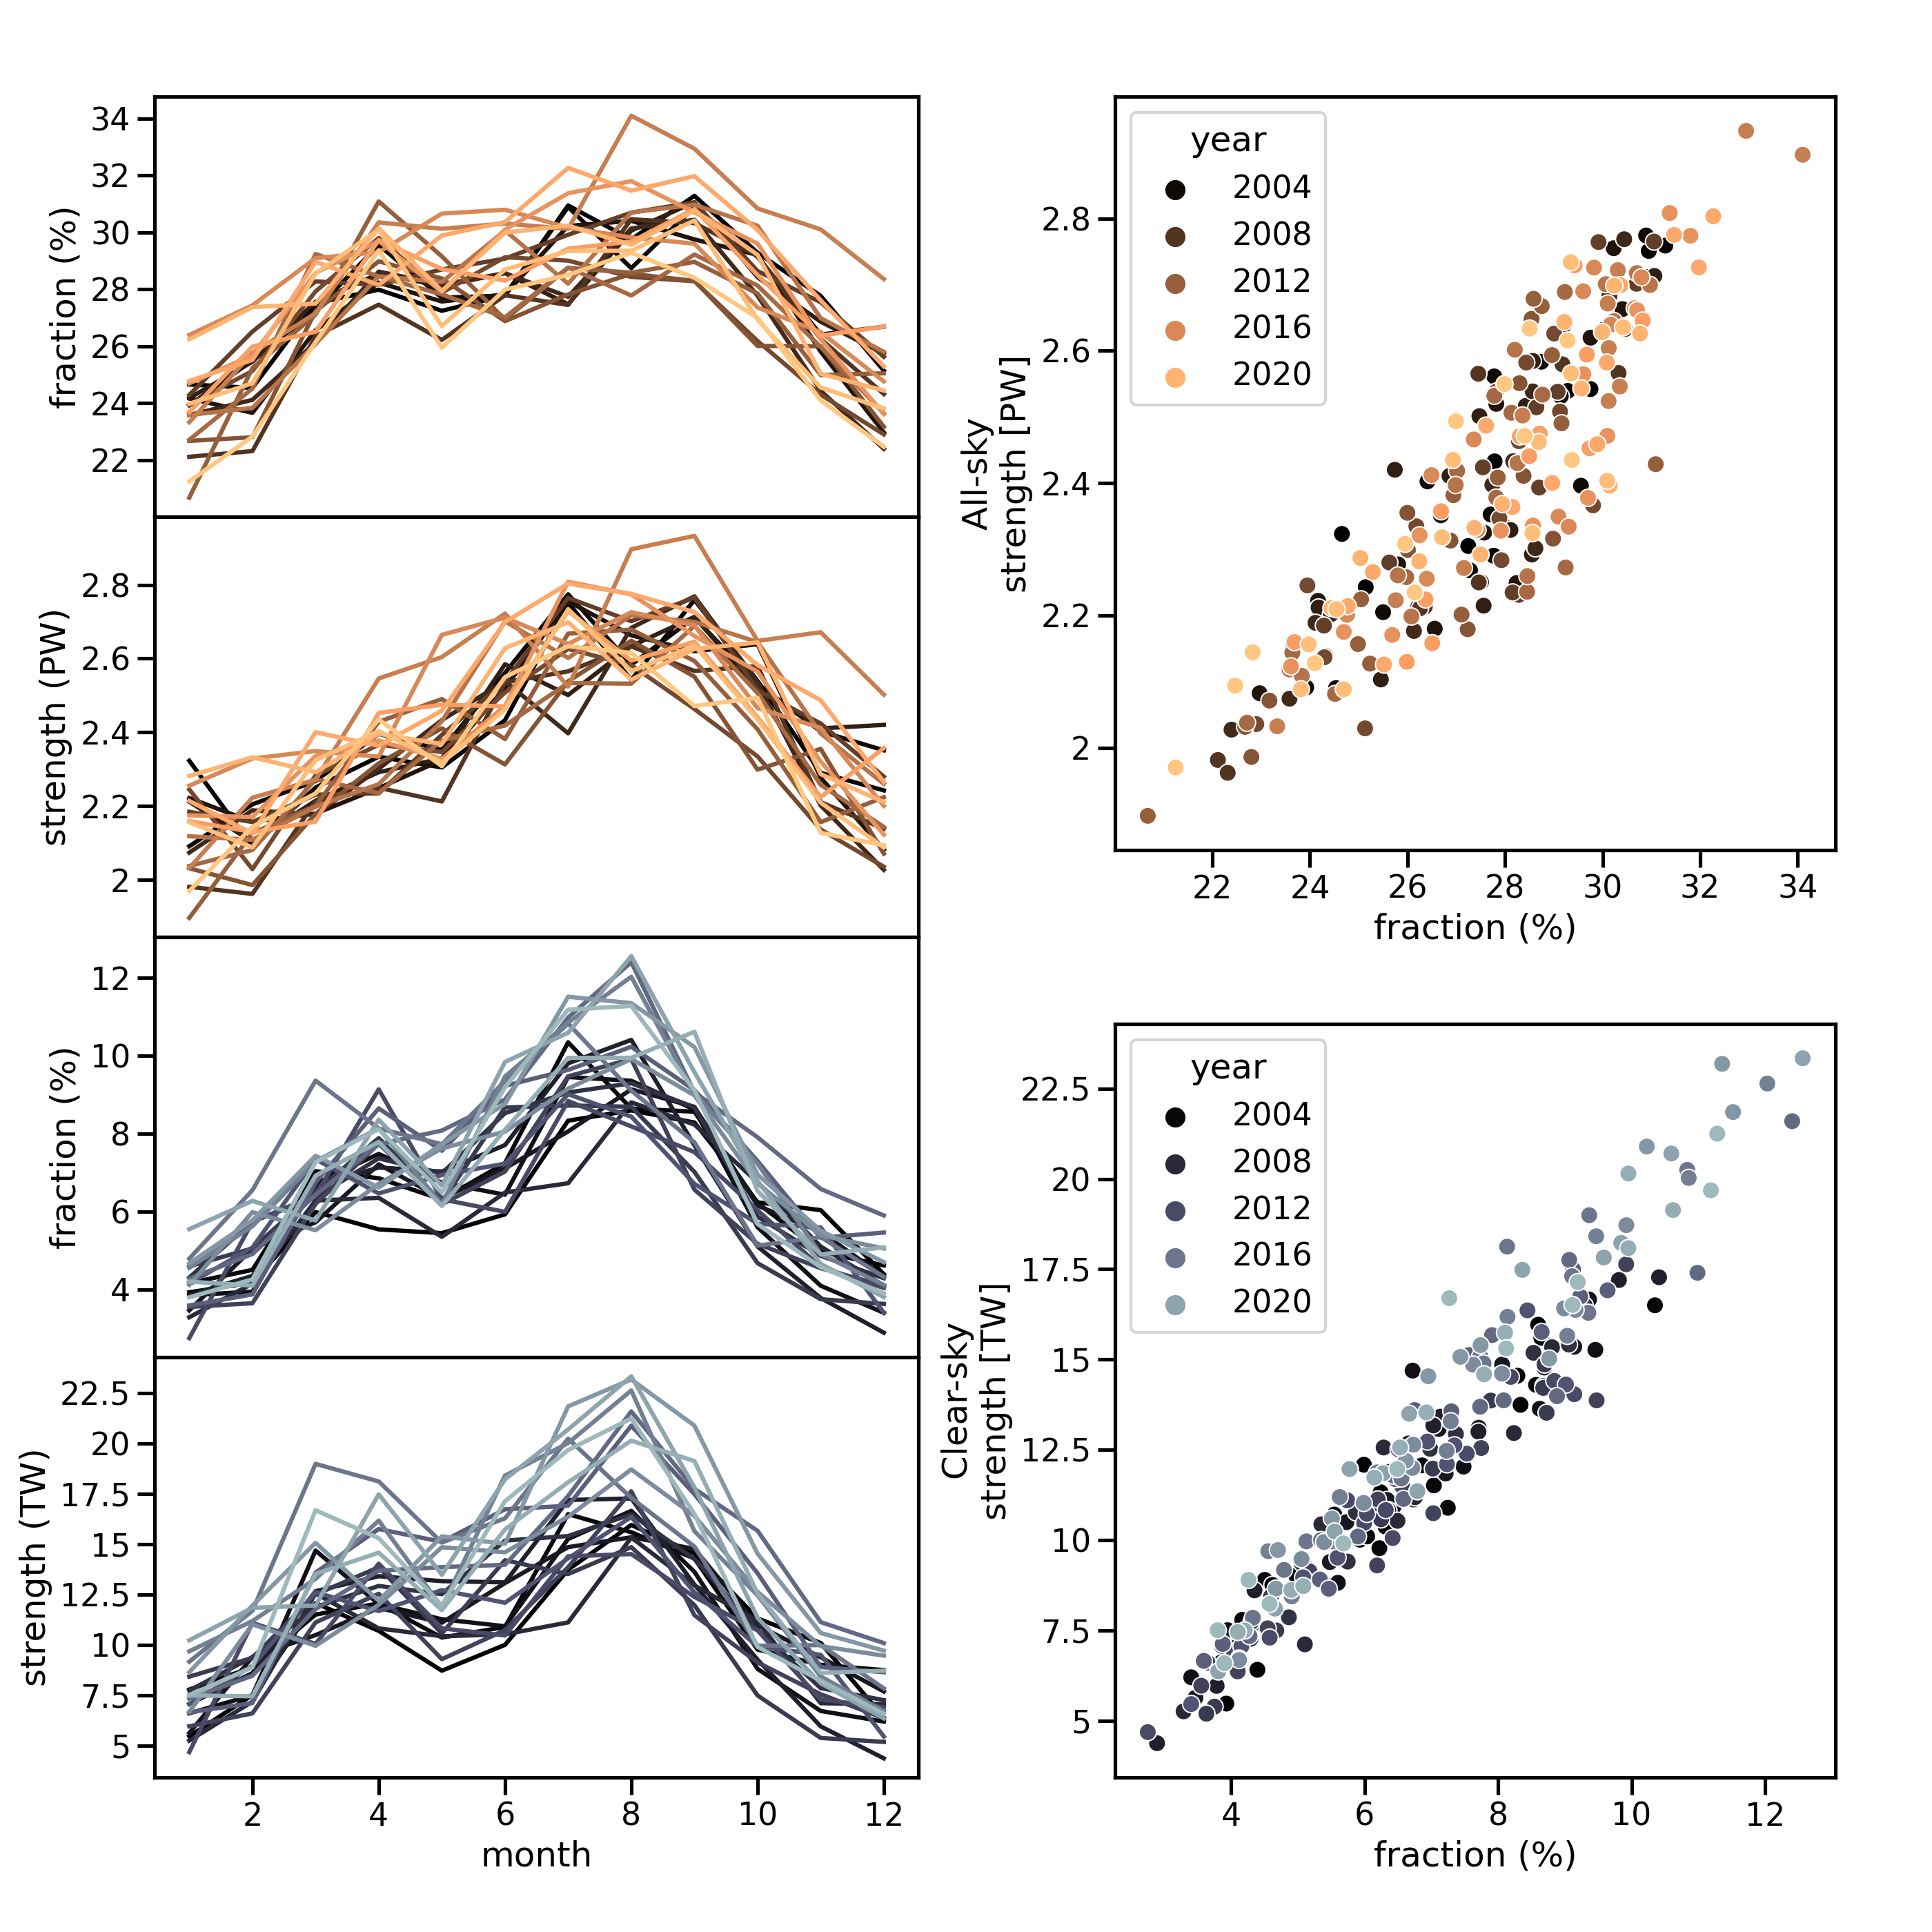

In [15]:
#Figure 2:
plt.rcdefaults()
with sns.plotting_context("talk"):
 
    fig = plt.figure(figsize=(14,14))
    gs_left = gridspec.GridSpec(ncols=4, nrows=4, hspace = 0.0, wspace = 0.5)
    gs_right = gridspec.GridSpec(ncols=4, nrows=4, hspace=0.6, wspace=1)
    fig.subplots_adjust(left=0.08, right=0.95, bottom=0.08, top=0.95)

    ax1 = fig.add_subplot(gs_left[0,0:2])
    sns.lineplot(ax=ax1,data=df_ALLmm, x='month',y='SGE_frac_all2',hue='year',palette='copper',legend=False)
    ax1.set_ylabel('fraction (%)')

    ax2 = fig.add_subplot(gs_left[1,0:2])
    sns.lineplot(ax=ax2,data=df_ALLmm, x='month',y='SGE_pw_all',hue='year',palette='copper',legend=False)
    ax2.set_ylabel('strength (PW)')

    ax3 = fig.add_subplot(gs_left[2,0:2])
    sns.lineplot(data=df_CLRmm, x='month',y='SGE_frac_clr2',hue='year',palette=cm.get_sub_cmap('bone', 0.0, 0.7),legend=False)
    ax3.set_ylabel('fraction (%)')

    ax4 = fig.add_subplot(gs_left[3,0:2])
    sns.lineplot(data=df_CLRmm, x='month',y='SGE_pw_clr',hue='year',palette=cm.get_sub_cmap('bone', 0.0, 0.7),legend=False)
    ax4.set_ylabel('strength (TW)')

    ax5 = fig.add_subplot(gs_right[0:2,2:4])
    sns.scatterplot(ax=ax5,data=df_ALLmm,x='SGE_frac_all2',y='SGE_pw_all',hue='year',palette='copper')
    #sns.regplot(ax=ax5,data=df_ALL,x='SGE_frac_all',y='SGE_pw_all',scatter=False,color='orange',ci=None,robust=True)
    ax5.set_ylabel(' All-sky \nstrength [PW]')
    ax5.set_xlabel('fraction (%)')

    ax6 = fig.add_subplot(gs_right[2:4,2:4])
    sns.scatterplot(ax=ax6,data=df_CLRmm,x='SGE_frac_clr2',y='SGE_pw_clr',hue='year',palette=cm.get_sub_cmap('bone', 0.0, 0.7))
    #sns.regplot(ax=ax6,data=df_CLR,x='SGE_frac_clr',y='SGE_pw_clr',scatter=False,color='skyblue',ci=None,robust=True)
    ax6.set_ylabel(' Clear-sky \nstrength [TW]')
    ax6.set_xlabel('fraction (%)')

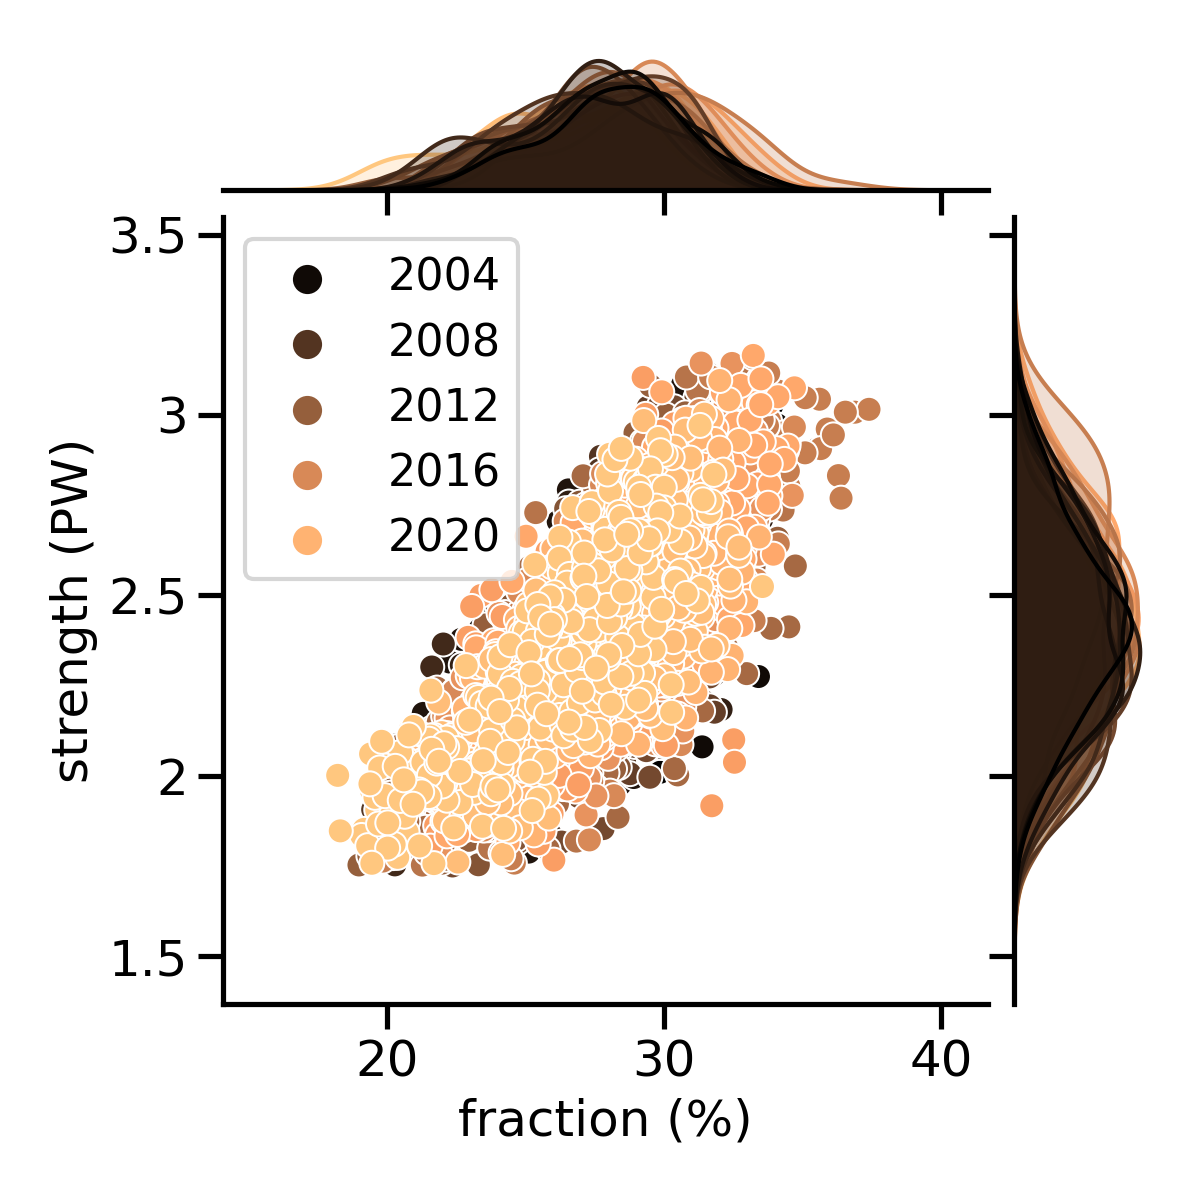

In [16]:
#supplimentary all-sky scatter:

with sns.plotting_context('talk'):
    fig = sns.jointplot(data=df_ALL,x='SGE_frac_all2',y='SGE_pw_all',hue='year',palette='copper')
    plt.xlabel('fraction (%)')
    plt.ylabel('strength (PW)')
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.legend(fontsize=16)

In [5]:
#supplimentary clear-sky scatter:
with sns.plotting_context('talk'):
    fig = sns.jointplot(data=df_CLR,x='SGE_frac_clr2',y='SGE_pw_clr',hue='year',palette=cm.get_sub_cmap('bone', 0.0, 0.7))
    plt.xlabel('fraction (%)')
    plt.ylabel('strength (TW)')
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.legend(fontsize=16)

NameError: name 'df_CLR' is not defined

In [3]:
#Figure 3: maps of frequency and strength

#seasonal means
occ_all_seas = SGE_ts.SGE_occ_all.where(SGE_ts['airs_flag']==0).groupby('time.season').mean('time')*100
occ_clr_seas = SGE_ts.SGE_occ_clr.groupby('time.season').mean('time')*100
str_all_seas = SGE_ts.SGE_str_all.where(SGE_ts['airs_flag']==0).groupby('time.season').mean('time')
str_clr_seas = SGE_ts.SGE_str_clr.groupby('time.season').mean('time')

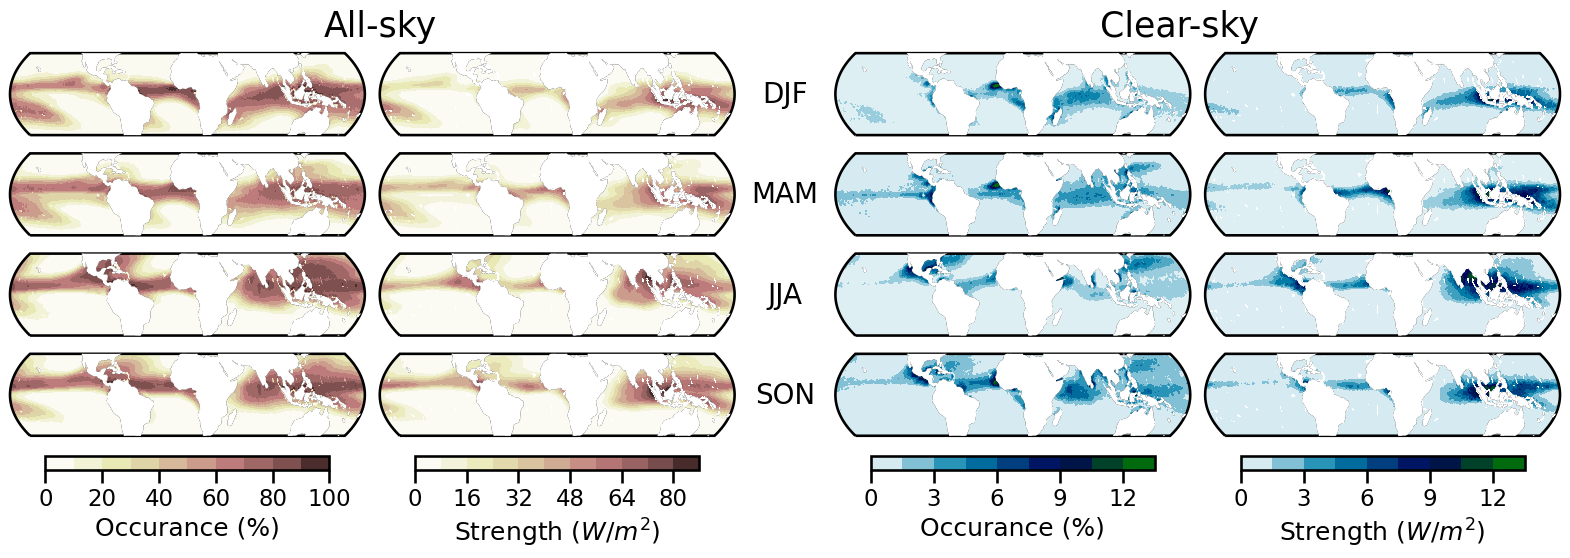

In [4]:
#Figure 3:

#WARNING: This figure does not render properly if proplot is loading (even if plt.rcdefaults() is called in this cell). 
# I don't have a solution, so to make Figure 3, resart the notebook with propolt commented out, import the data and run the cell above and this one. 

import matplotlib.ticker as ticker
with sns.plotting_context('talk'):

    fig = plt.figure(figsize=(20,6))
    proj=ccrs.Mollweide()
    all_cmap = 'pink_r'
    clr_cmap = 'ocean_r'
    lats=occ_all_seas.lat
    lons=occ_all_seas.lon
    gs = gridspec.GridSpec(ncols=5, nrows=5, hspace = 0.0, wspace = 0.05, height_ratios=[1,1,1,1,0.43], width_ratios=[1,1,0.2,1,1], figure=fig)

    ax1 = fig.add_subplot(gs[0,0], projection=proj)
    plt.contourf(lons,lats,occ_all_seas.sel(season='DJF'),10,transform=ccrs.PlateCarree(),cmap=all_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=5)
    plt.gca().coastlines()

    #plt.subplot(445, projection=proj)
    ax2 = fig.add_subplot(gs[1,0], projection=proj)
    plt.contourf(lons,lats,occ_all_seas.sel(season='MAM'),10,transform=ccrs.PlateCarree(),cmap=all_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    #plt.subplot(449, projection=proj)
    ax3 = fig.add_subplot(gs[2,0], projection=proj)
    plt.contourf(lons,lats,occ_all_seas.sel(season='JJA'),10,transform=ccrs.PlateCarree(),cmap=all_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    #ax4=plt.subplot(4,4,13, projection=proj)
    ax4 = fig.add_subplot(gs[3,0], projection=proj)
    im=plt.contourf(lons,lats,occ_all_seas.sel(season='SON'),10,transform=ccrs.PlateCarree(),cmap=all_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()
    ax5 = fig.add_subplot(gs[4,0], projection=proj)
    plt.colorbar(im,ax=ax5, location='bottom',label='Occurance (%)',fraction=0.75,shrink=0.8)
    fig.delaxes(ax5)


    #plt.subplot(442, projection=proj)
    ax7 = fig.add_subplot(gs[0,1], projection=proj)
    plt.contourf(lons,lats,str_all_seas.sel(season='DJF'),10,transform=ccrs.PlateCarree(),cmap=all_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    #plt.subplot(446, projection=proj)
    ax8 = fig.add_subplot(gs[1,1], projection=proj)
    plt.contourf(lons,lats,str_all_seas.sel(season='MAM'),10,transform=ccrs.PlateCarree(),cmap=all_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    #plt.subplot(4,4,10, projection=proj)
    ax9 = fig.add_subplot(gs[2,1], projection=proj)
    plt.contourf(lons,lats,str_all_seas.sel(season='JJA'),10,transform=ccrs.PlateCarree(),cmap=all_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    #ax5=plt.subplot(4,4,14, projection=proj)
    ax10 = fig.add_subplot(gs[3,1], projection=proj)
    im2=plt.contourf(lons,lats,str_all_seas.sel(season='SON'),10,transform=ccrs.PlateCarree(),cmap=all_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()
    ax11 = fig.add_subplot(gs[4,1], projection=proj)
    plt.colorbar(im2,ax=ax11, location='bottom',label='Strength ($W/m^2$)',fraction=0.75,shrink=0.8)
    fig.delaxes(ax11)


    #plt.subplot(443, projection=proj)
    ax12 = fig.add_subplot(gs[0,3], projection=proj)
    plt.contourf(lons,lats,occ_clr_seas.sel(season='DJF'),10,transform=ccrs.PlateCarree(),cmap=clr_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    #plt.subplot(447, projection=proj)
    ax13 = fig.add_subplot(gs[1,3], projection=proj)
    plt.contourf(lons,lats,occ_clr_seas.sel(season='MAM'),10,transform=ccrs.PlateCarree(),cmap=clr_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    #plt.subplot(4,4,11, projection=proj)
    ax13 = fig.add_subplot(gs[2,3], projection=proj)
    plt.contourf(lons,lats,occ_clr_seas.sel(season='JJA'),10,transform=ccrs.PlateCarree(),cmap=clr_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    #ax6=plt.subplot(4,4,15, projection=proj)
    ax14 = fig.add_subplot(gs[3,3], projection=proj)
    im3=plt.contourf(lons,lats,occ_clr_seas.sel(season='SON'),10,transform=ccrs.PlateCarree(),cmap=clr_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()
    ax15 = fig.add_subplot(gs[4,3], projection=proj)
    l1=im3.levels
    plt.colorbar(im3,ax=ax15, location='bottom',label='Occurance (%)',fraction=0.75,shrink=0.8,ticks=l1[::2])
    fig.delaxes(ax15)   

    #plt.subplot(444, projection=proj)
    ax16 = fig.add_subplot(gs[0,4], projection=proj)
    plt.contourf(lons,lats,str_clr_seas.sel(season='DJF'),10,transform=ccrs.PlateCarree(),cmap=clr_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    #plt.subplot(448, projection=proj)
    ax17 = fig.add_subplot(gs[1,4], projection=proj)
    plt.contourf(lons,lats,str_clr_seas.sel(season='MAM'),10,transform=ccrs.PlateCarree(),cmap=clr_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    #plt.subplot(4,4,12, projection=proj)
    ax18 = fig.add_subplot(gs[2,4], projection=proj)
    plt.contourf(lons,lats,str_clr_seas.sel(season='JJA'),10,transform=ccrs.PlateCarree(),cmap=clr_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    #ax7=plt.subplot(4,4,16, projection=proj)
    ax19 = fig.add_subplot(gs[3,4], projection=proj)
    im4= plt.contourf(lons,lats,str_clr_seas.sel(season='SON'),10,transform=ccrs.PlateCarree(),cmap=clr_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()
    ax20 = fig.add_subplot(gs[4,4], projection=proj)
    l2 = im4.levels
    plt.colorbar(im4,ax=ax20, location='bottom',label='Strength ($W/m^2$)',fraction=0.75,shrink=0.8, ticks=l2[::2])
    fig.delaxes(ax20)

#fig.tight_layout()
fig.subplots_adjust(top=0.85)  
plt.figtext(0.31,0.88,"All-sky", va="center", ha="center", size=25)
plt.figtext(0.71,0.88,"Clear-sky", va="center", ha="center", size=25)
#add labels into center column:
labels = ['DJF','MAM','JJA','SON']
for ii in range(4):
    ax_label = fig.add_subplot(gs[ii,2])
    ax_label.text(0.5,0.5,labels[ii], horizontalalignment='center', verticalalignment='center', transform=ax_label.transAxes, fontsize=20)
    ax_label.set_axis_off()


In [19]:
# calculate deseasonalized trend with seasonal mean removed at each gridpoint:
# WARNING: cell takes a long time to run, the processed trend timeseries data can be uploaded below.

vars = ['str_clr','str_all', 'occ_all','occ_clr']

for var in vars:
    trends = np.zeros((70,360))
    ts = SGE_ts['SGE_'+var].where(SGE_ts['airs_flag']==0).sel(time=slice('2003', '2022')).resample(time='M', skipna=True).mean()

    for ii in np.arange(70):
        for jj in np.arange(360):
            ts_mm = ts[:,ii,jj].to_dataframe()
            ts_mm.index = pd.to_datetime(ts_mm.index)
            sm = ts_mm.groupby([ts_mm.index.day, ts_mm.index.month]).transform('mean')
            ts_ds = (ts_mm - sm).reset_index() #remove seasonal mean
            idx = np.isfinite(ts_ds['SGE_'+var])
            if any(idx):
                t = np.arange(np.size(ts_ds['SGE_'+var]))
                lin_trend = np.polyfit(t[idx], ts_ds['SGE_'+var][idx], 1) #calculate linear trend through de-seasonalized timeseries
                trends[ii,jj] = lin_trend[0]
    
    np.savetxt('SGE_'+var+'_trends3.txt',trends)


In [20]:
#get trend already calculate from above cell.
trends_occ_all = np.loadtxt('SGE_occ_all_trends3.txt')
trends_str_all = np.loadtxt('SGE_str_all_trends3.txt')
trends_occ_clr = np.loadtxt('SGE_occ_clr_trends3.txt')
trends_str_clr = np.loadtxt('SGE_str_clr_trends3.txt')

/home/mdewey/sge_env/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/mdewey/sge_env/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/mdewey/sge_env/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/mdewey/sge_env/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keywor

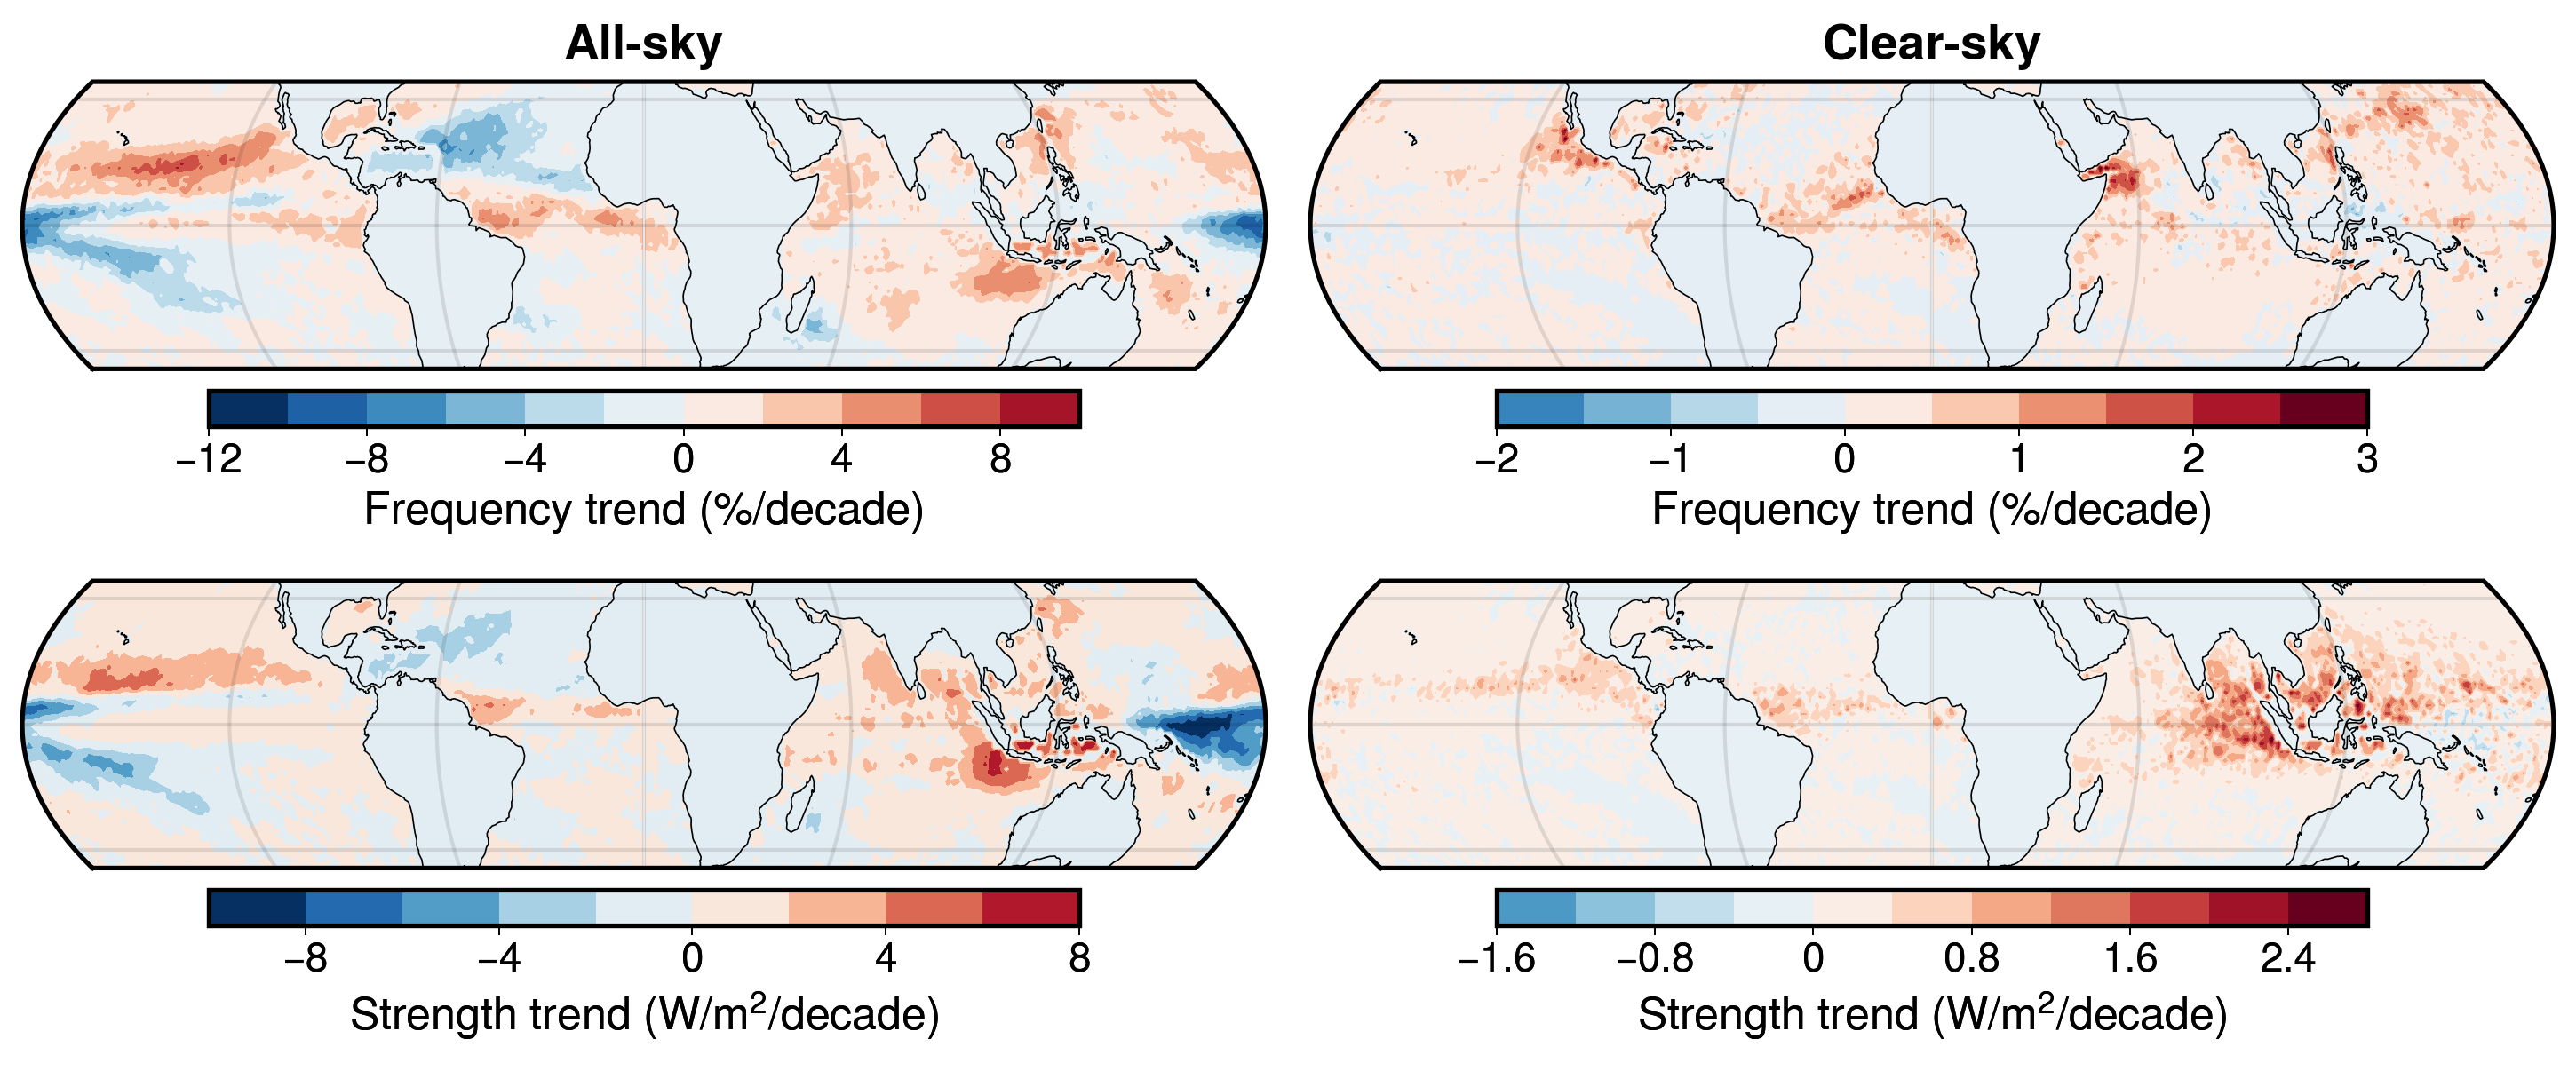

In [22]:
#Figure 4:

with sns.plotting_context('talk'):

    fig, axs = pplt.subplots(nrows=2, ncols=2, proj=ccrs.Mollweide(),refwidth=7)
    axs.format(coast=True, landcolor='white', toplabels=('All-sky','Clear-sky'))
    lats=SGE_ts.lat
    lons=SGE_ts.lon

    m0=axs[0].contourf(lons,lats,trends_occ_all*12000,transform=ccrs.PlateCarree())
    axs[0].colorbar(m0,loc='b',length=0.7,label='Frequency trend (%/decade)')
    m2=axs[2].contourf(lons,lats,trends_str_all*120,transform=ccrs.PlateCarree())
    axs[2].colorbar(m2,loc='b',length=0.7, label='Strength trend ($W/m^2/$decade)')

    m1=axs[1].contourf(lons,lats,trends_occ_clr*12000,transform=ccrs.PlateCarree())
    axs[1].colorbar(m1,loc='b',length=0.7, label='Frequency trend (%/decade)')
    m3=axs[3].contourf(lons,lats,trends_str_clr*120,transform=ccrs.PlateCarree())
    axs[3].colorbar(m3,loc='b',length=0.7, label='Strength trend ($W/m^2/$decade)')

    #pplt.rc['cartopy.autoextent']=True
    pplt.rc['figure.facecolor']='w'

Text(0, 0.5, 'Fraction of data availability')

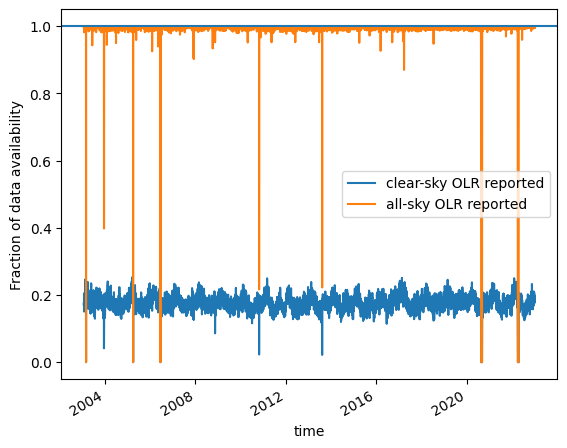

In [19]:
# supplimentary: fraction of tropical area with all- and clear-sky measurements:
from SGE_utils import earth_radius 

xlon, ylat = np.meshgrid(SGE_ts.lon, SGE_ts.lat)
R = earth_radius(ylat)
dlat = np.deg2rad(np.gradient(ylat, axis=0))
dlon = np.deg2rad(np.gradient(xlon, axis=1))
dy = dlat * R
dx = dlon * R * np.cos(np.deg2rad(ylat))
area_grid = dy * dx * SGE_ts.landmask
tot_area = area_grid.sum()

((SGE_ts.clr_flag*area_grid).sum(dim=['lat','lon'])/tot_area).plot(label='clear-sky OLR reported')
((SGE_ts.all_flag*area_grid).sum(dim=['lat','lon'])/tot_area).plot(label='all-sky OLR reported')
plt.axhline(y=1)
plt.legend()
plt.ylabel('Fraction of data availability')

-2.244806380398185
-3.4522495744654713
-3.0348869187149092
-3.0313317064059326


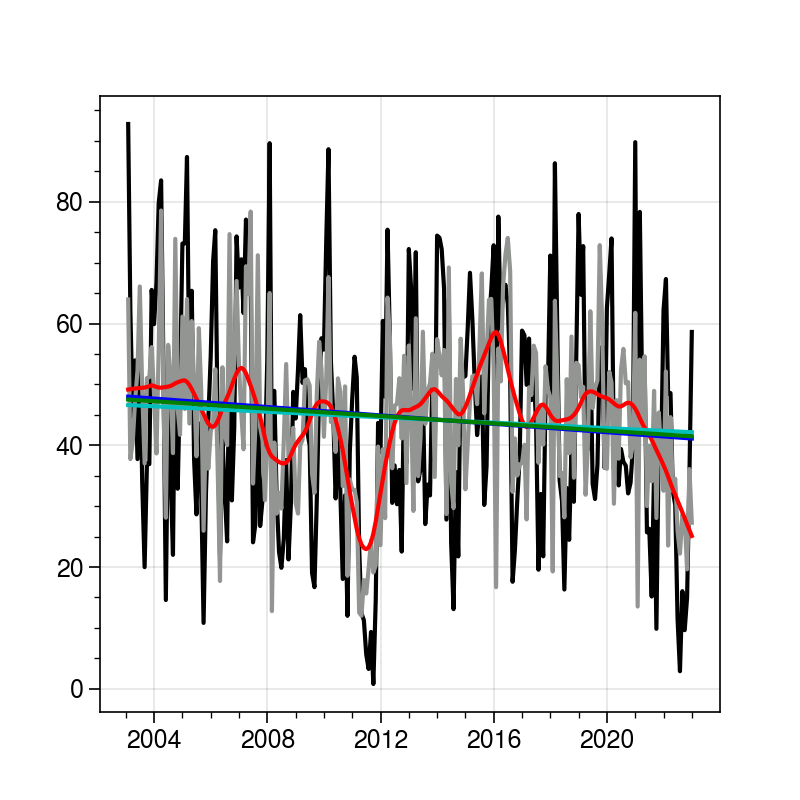

In [84]:
#testing ideas for calculating gridwise trend.

#pick one grid point to test trend analysis on: -9.5S, 180W
test_grid=SGE_ts['SGE_str_all'][:,25,180]

#use monthly means to account for the fact that sometimes there is no SGE in a grid point on a given individual day.
#also start and stop on Jan 1 so even number of seasonal cycles are retained. 
test_grid_mm = test_grid.resample(time='M', skipna=True).mean().sel(time=slice('2003', '2022')) 

#according to the STL paper: np=12, nl=13, nt=default, ns=21, robust=True
stl_grid = STL(test_grid_mm, period=12, seasonal=21, robust=True)
res_grid = stl_grid.fit()


xs = np.arange(np.size(test_grid_mm['time']))
test_lin = np.polyfit(xs, test_grid_mm.values, 1)
a1 = test_lin[0]
b1 = test_lin[1]
grid_linear = a1*xs + b1

plt.plot(test_grid_mm['time'], test_grid_mm, 'k') #monthly means
plt.plot(test_grid_mm['time'], test_grid_mm-res_grid.seasonal,'grey' ) #monthly means with STL seasonal removed
plt.plot(test_grid_mm['time'],  res_grid.trend, 'r') #STL trend

lin_trend = np.polyfit(xs, res_grid.trend, 1)
a = lin_trend[0]
b = lin_trend[1]
linear_from_trend = a*xs + b
plt.plot(test_grid_mm['time'], linear_from_trend, 'c') #linear trend fit to STL trend
plt.plot(test_grid_mm['time'], grid_linear,'b') #linear trend fit to monthly means

lin_seas = np.polyfit(xs, test_grid_mm-res_grid.seasonal, 1)
a2 = lin_seas[0]
b2 = lin_seas[1]
linear_seas = a2*xs + b2
plt.plot(test_grid_mm['time'], linear_seas, 'g') #linear trend fit to monhtly mean minus STL seasonal

test_griddf = test_grid_mm.to_dataframe()
test_griddf.index = pd.to_datetime(test_griddf.index)
season_mean = test_griddf.groupby([test_griddf.index.day,test_griddf.index.month]).transform('mean')
deseas_df = (test_griddf-season_mean).reset_index()
idx = np.isfinite(deseas_df.SGE_str_all)
t = np.arange(np.size(deseas_df.SGE_str_all))
trend = np.polyfit(t[idx], deseas_df.SGE_str_all[idx], 1)#linear trend fitted to mean deseasonalized data


print(a*12*10) #linear fitted to res.trend
print(a1*12*10) #fitted to original data
print(a2*12*10) #fitted to data-res.seasonal
print(trend[0]*120) #fitted to data-annualmean

-3.9626157258235315
0.29090131326271884


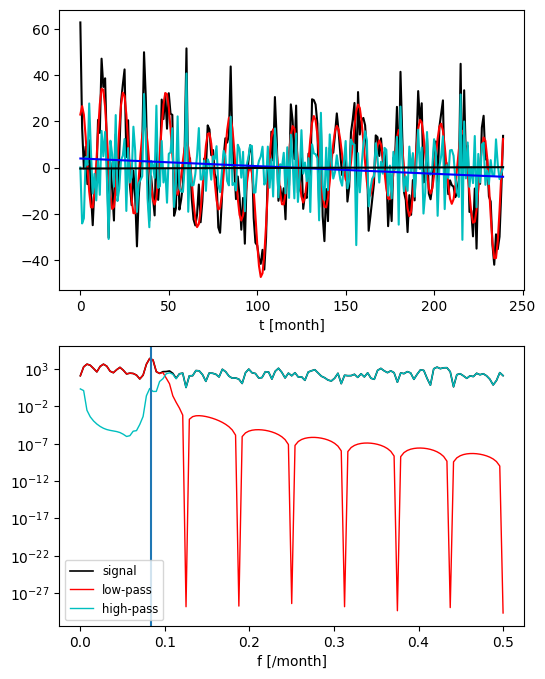

In [19]:
from scipy import signal

test_grid_nomean = test_grid_mm - test_grid_mm.mean()
xn = test_grid_nomean.values

N=len(xn)
dt=1.
nfft=256
args={'nfft':nfft, 'fs':1./dt, 'window':'hann'}

f, pxx = signal.periodogram(xn,**args)
t=np.arange(0,N*dt,dt)

X=np.fft.fft(xn)
ff = np.linspace(0,1./dt,N)
X[(ff>0.1) & (ff<(1./dt-0.1))]=1.e-15
y = np.real(np.fft.ifft(X))+np.mean(xn)
fff, pyy = signal.periodogram(y,**args)

lin_trend = np.polyfit(t, y, 1)
a = lin_trend[0]
b = lin_trend[1]
linear_deseas = a*xs + b


def highpass(data: np.ndarray, cutoff: float, sample_rate: float, poles: int = 12):
    sos = signal.butter(poles, cutoff, 'highpass', fs=sample_rate, output='sos')
    filtered_data = signal.sosfiltfilt(sos, data)
    return filtered_data


# Apply a 20 Hz high-pass filter to the original data
filtered2 = highpass(xn, 1/10, 1)
f2,p2 = signal.periodogram(filtered2,**args)
lin_2= np.polyfit(t, filtered2, 1)
a2 = lin_2[0]
b2 = lin_2[1]
linear_2 = a2*xs + b2

fig,ax=plt.subplots(2,1,figsize=(6,8))
ax[0].plot(t,xn,color="k",label='signal')
ax[0].plot(t,y,color='r',label='low-pass')
ax[0].plot(t,filtered2,color='c',label='high-pass')
ax[0].set_xlabel('t [month]')
#ax[0].plot(t,xn-y,color='b',alpha=0.5,label='difference')
ax[0].plot(t,linear_deseas,color='b',label='trend')
ax[0].plot(t,linear_2,color='k')

# spectrum
ax[1].semilogy(f,pxx,'k',linewidth=1.2,label="signal")
ax[1].semilogy(fff,pyy,'r',linewidth=1,label='low-pass')
ax[1].semilogy(f2,p2,'c',linewidth=1,label='high-pass')
ax[1].set_xlabel('f [/month]')
ax[1].axvline(x=1/12)

#ax[1].set_ylim((1.e-2,10.e5))
#ax[1].set_ylabel(r'$P_{xx} \mathrm{[V^2 Hz^{-1}]}$')
ax[1].legend(fontsize='small')

print(a*12*10)
print(a2*12*10)


In [ ]:
#10pt lowpass butterworth filter:
#copied from Mann 2008: https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2008GL034716, http://www.meteo.psu.edu/holocene/public_html/smoothing08/
#(probably should re-write to proper python package sometime)
'''
def lowpass_mann(indata, f, iconb, icone):
    #f is the cutoff frequency (in cycles/time units)
    #icon is options for boundary constraints:
    # (0) minimum norm,
    # (1) minimum slope,
    # (2) minimum roughness
    padded=()
    ipts=10
    fn=f*2
    npad=3*round(1/fn)
    nn=len(indata)
    padded[npad:npad+nn-1]=indata
    padded[npad+nn:nn+2*npad-1]=indata[nn]
    padded[0:npad-1]=indata[1]
'''

cutoff = 1/30
b, a = signal.butter(10, cutoff, btype='lowpass') 
yfilt = signal.filtfilt(b, a, y, method='pad')
yfilt=np.array(yfilt)
yfilt=yfilt.transpose()

plt.plot(y,'r')
plt.plot(yfilt,'b',linewidth=1)